In [32]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

seeds = []
for i in range(1, 101):
    seeds.append(i)


def time_to_minutes(timestr):
    # Handle '+1' suffix by removing it before parsing
    timestr = timestr.split('+')[0]  # Remove '+1' if present
    hh, mm = timestr.split(':')
    return int(hh) * 60 + int(mm)


def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.
    
    Slack is defined as:
        Slack = 1 - (total flight minutes in recovery period / total recovery period aircraft-minutes)
    
    A slack of 1 means no flights during recovery period.
    A slack of 0 means flights occupy the entire recovery period.
    """
    def time_to_minutes(timestr):
        # Handle '+1' suffix by removing it before parsing
        timestr = timestr.split('+')[0]  # Remove '+1' if present
        hh, mm = timestr.split(':')
        return int(hh) * 60 + int(mm)

    
    # Extract scenario start/end times
    # We assume the same date for start and end for simplicity.
    recovery_start_time_str = scenario_data["recovery_start_time"]  
    recovery_end_time_str = scenario_data["recovery_end_time"]      
    
    recovery_start_minutes = time_to_minutes(recovery_start_time_str)
    recovery_end_minutes = time_to_minutes(recovery_end_time_str)
    total_recovery_period_minutes = recovery_end_minutes - recovery_start_minutes
    
    total_aircraft = scenario_data["total_aircraft"]
    
    # Calculate total flight minutes within the recovery period
    flights = scenario_data["flights"]
    total_flights = len(flights)
    total_flight_minutes_in_recovery = 0
    total_flight_minutes_total = 0
    
    for flight_id, flight_data in flights.items():
        dep_time_str = flight_data["DepTime"]  
        arr_time_str = flight_data["ArrTime"] 
        
        dep_minutes = time_to_minutes(dep_time_str)
        arr_minutes = time_to_minutes(arr_time_str)
        
        total_flight_minutes_total += arr_minutes - dep_minutes
        overlap_start = max(dep_minutes, recovery_start_minutes)
        overlap_end = min(arr_minutes, recovery_end_minutes)
        
        if overlap_end > overlap_start:
            flight_overlap = overlap_end - overlap_start
        else:
            flight_overlap = 0
        
        total_flight_minutes_in_recovery += flight_overlap
    
    # Calculate total aircraft-minutes available during the recovery period
    total_recovery_aircraft_minutes = total_recovery_period_minutes * total_aircraft
    
    # Slack calculation
    if total_recovery_aircraft_minutes == 0:
        slack = 1.0
    else:
        slack = 1 - (total_flight_minutes_in_recovery / total_recovery_aircraft_minutes)
    
    return slack, total_flights, total_flight_minutes_total


def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  
    
    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob, total_aircraft

# Path to the scenarios folder
scenario_folder_path = "../logs/scenarios/"
# latest_folder = max(
#     [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
#     key=lambda x: int(x.split('_')[-1].replace('.json', ''))
# )

# latest_folder = "scenario_folder_scenario_74.json" # Training/6ac-10-superdiverse

# latest_folder = "scenario_folder_scenario_77.json" # Training/6ac-10000-superdiverse
latest_folder = "scenario_folder_scenario_4.json" # Testing/6ac-700-diverse

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']


# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack, total_flights, total_flight_minutes_total = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob, total_aircraft = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "TotalFlights": total_flights,
        "TotalFlightMinutes": total_flight_minutes_total,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob,
        "TotalAircraft": total_aircraft
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)

# Save the slack results to CSV
# output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
# scenarios_df.to_csv(output_file, index=False)
# print(f"Slack metrics saved to {output_file}")


Scenario ID: 4
Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario  ScenarioSlack  TotalFlights  \
0    deterministic_na_Scenario_001       0.349048            21   
1    deterministic_na_Scenario_002       0.369713            21   
2    deterministic_na_Scenario_003       0.420513            13   
3    deterministic_na_Scenario_004       0.441493            16   
4    deterministic_na_Scenario_005       0.484896            14   
..                             ...            ...           ...   
695        mixed_high_Scenario_096       0.479683            15   
696        mixed_high_Scenario_097       0.460082            13   
697        mixed_high_Scenario_098       0.424324            20   
698        mixed_high_Scenario_099       0.407037            15   
699        mixed_high_Scenario_100       0.428228            18   

     TotalFlightMinutes  FullyDisruptedCount  UncertainCount  \
0                  4101                    2               0   
1     

<div class="alert alert-block alert-success">
</br>
</br>
</br>
<b>DONE: </b>MERGED DATASET
</br>
</br>
</br>
</br>
</div>

In [33]:
import os
import pandas as pd

scenario_folder_path = "../logs/scenarios/"
# unpack results_df
# results_df = pd.read_csv(os.path.join(scenario_folder_path, f"2_temp_seeds_{len(seeds)}.csv"))
results_df = pd.read_csv(os.path.join(scenario_folder_path, f"final_final_results_df_in_rapport_seeds_{len(seeds)}.csv"))


# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

# Sort models in desired order
model_order = ['proactive', 'myopic', 'reactive', 'greedy_reactive']
merged_df['Model_Type'] = merged_df['Model'].str.extract('(' + '|'.join(model_order) + ')')
merged_df = merged_df.sort_values('Model_Type')
merged_df["Model"] = merged_df["Model_Type"]
merged_df = merged_df.drop('Model_Type', axis=1)
merged_df_backup = merged_df.copy()


# Update model names in merged_df
merged_df['Model'] = merged_df['Model'].apply(lambda x: 
    'DQN Proactive-U' if x.startswith('proactive') else
    'DQN Proactive-N' if x.startswith('myopic') else 
    'DQN Reactive' if x.startswith('reactive') else
    'Greedy Reactive' if x.startswith('greedy_reactive') else
    x
)

print("Inference Results (After Merging):")
print(merged_df)

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")



# print all column names
print("==== Columns: ====")
print(merged_df.columns)

print("==== amount of rows: ====")
print(len(merged_df))

print("==== Models: ====")
print(merged_df["Model"].unique())

print('===== len(seeds) =====')
print(len(merged_df['Seed'].unique()))

print('===== len(scenarios) =====')
print(len(merged_df['Scenario'].unique()))





Inference Results (After Merging):
                              Scenario            Model  Seed  TotalReward  \
139999     stochastic_low_Scenario_093  Greedy Reactive   100       -217.6   
130773          mixed_low_Scenario_063  Greedy Reactive    74      24786.2   
130772          mixed_low_Scenario_063  Greedy Reactive    73      24786.2   
130771          mixed_low_Scenario_063  Greedy Reactive    72      19799.3   
130770          mixed_low_Scenario_063  Greedy Reactive    71      19799.3   
...                                ...              ...   ...          ...   
222263  stochastic_medium_Scenario_085     DQN Reactive    64       9612.9   
222262  stochastic_medium_Scenario_085     DQN Reactive    63       -217.0   
222261  stochastic_medium_Scenario_085     DQN Reactive    62       -217.0   
222268  stochastic_medium_Scenario_085     DQN Reactive    69       9612.9   
35000      stochastic_low_Scenario_091     DQN Reactive     1        -90.8   

        TotalDelays  TotalCa

<div class="alert alert-block alert-info">
<b>Check: </b>Comparison of Models Across All Scenarios
</div>

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# First aggregate by Model and Seed, then calculate mean and std across seeds
comparison_table = (
    merged_df
    .groupby(['Model', 'Seed'])
    .agg(
        TotalReward=('TotalReward', 'mean'),
        ScenarioTime=('ScenarioTime', 'mean'), 
        ScenarioSteps=('ScenarioSteps', 'mean'),
        TotalDelays=('TotalDelays', 'mean'),
        TotalCancelledFlights=('TotalCancelledFlights', 'mean'),
        TotalTailSwaps=('TailSwaps', 'mean')
    )
    .groupby('Model')
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Std_Reward=('TotalReward', 'std'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Std_Runtime=('ScenarioTime', 'std'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Std_Steps=('ScenarioSteps', 'std'),
        Mean_Delays=('TotalDelays', 'mean'),
        Std_Delays=('TotalDelays', 'std'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
        Std_CancelledFlights=('TotalCancelledFlights', 'std'),
        Mean_TailSwaps=('TotalTailSwaps', 'mean'),
        Std_TailSwaps=('TotalTailSwaps', 'std')
    )
    .round(2)
)

# Sort the comparison table according to model order
comparison_table['Model_Type'] = comparison_table.index.map(lambda x: next(m for m in model_order if m in x.lower()))
comparison_table = comparison_table.sort_values('Model_Type')
comparison_table = comparison_table.drop('Model_Type', axis=1)

print("Comparison of Models Across All Scenarios:")
print(comparison_table)


Comparison of Models Across All Scenarios:
                 Mean_Reward  Std_Reward  Mean_Runtime  Std_Runtime  \
Model                                                                 
DQN Proactive-N      6198.37      474.22          0.03          0.0   
DQN Proactive-U     10186.83      535.50          0.03          0.0   
DQN Reactive        -4062.91      443.99          0.03          0.0   
Greedy Reactive     32888.75      403.08          0.17          0.0   

                 Mean_Steps  Std_Steps  Mean_Delays  Std_Delays  \
Model                                                             
DQN Proactive-N        7.52       0.03       343.03        4.18   
DQN Proactive-U        7.44       0.03       301.04        3.25   
DQN Reactive           7.95       0.04       226.31        5.54   
Greedy Reactive        6.89       0.02        19.58        2.53   

                 Mean_CancelledFlights  Std_CancelledFlights  Mean_TailSwaps  \
Model                                          

<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Overall reward comparison
</br>
</br>
</br>
</div>

DQN Proactive-U
DQN Proactive-N
DQN Reactive
Greedy Reactive


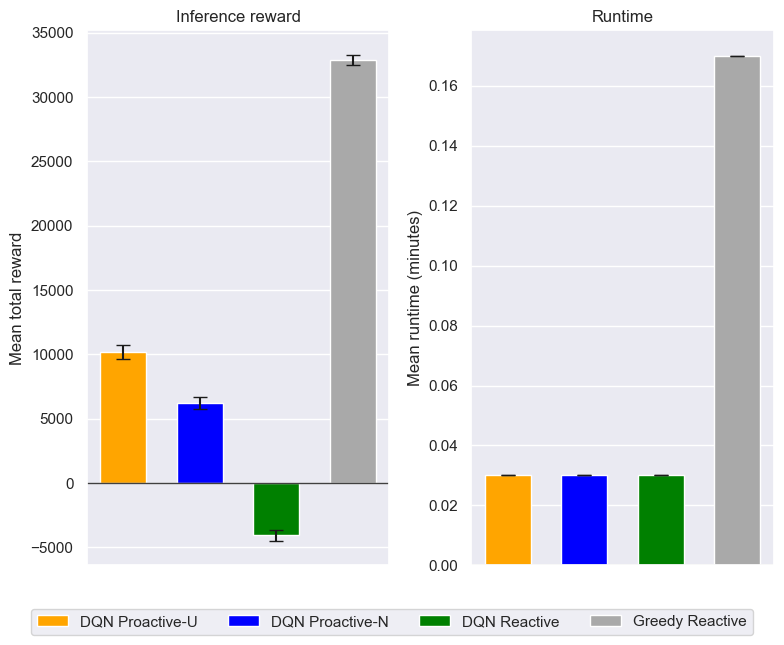

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Define desired order of models
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}
# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.6

# Plot reward bars using model colors in specified order
for i, model in enumerate(sorted_models):
    print(model)
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax1.bar(i, comparison_table.loc[model, 'Mean_Reward'], width,
            yerr=comparison_table.loc[model, 'Std_Reward'],
            capsize=5, label=label, color=color)

ax1.set_ylabel('Mean total reward')
ax1.set_title('Inference reward')
ax1.set_xticks([])
ax1.axhline(y=0, color='#404040', linewidth=1)  # Add darker gray horizontal line

# Plot runtime bars
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax2.bar(i, comparison_table.loc[model, 'Mean_Runtime'], width,
            yerr=comparison_table.loc[model, 'Std_Runtime'],
            capsize=5, color=color)  # Removed label here since we only want one legend

ax2.set_ylabel('Mean runtime (minutes)')
ax2.set_title('Runtime')
ax2.set_xticks([])
ax2.axhline(y=0, color='#404040', linewidth=1)  # Add darker gray horizontal line

# Add legend centered below the plots with 2 columns
fig.legend(ncol=4, bbox_to_anchor=(0.5, -0.05), loc='center')

plt.tight_layout()
plt.show()


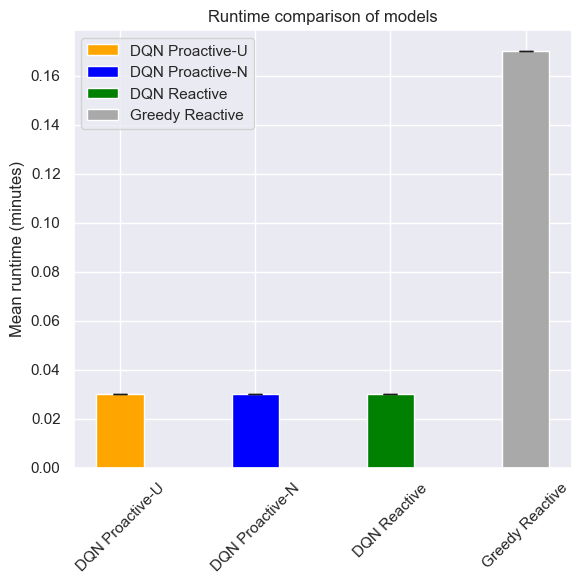

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Define desired order of models
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}
# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.35

# Plot bars using model colors in specified order
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax.bar(i, comparison_table.loc[model, 'Mean_Runtime'], width,
           yerr=comparison_table.loc[model, 'Std_Runtime'],
           capsize=5, label=label, color=color)

ax.set_ylabel('Mean runtime (minutes)')
ax.set_title('Runtime comparison of models')
ax.set_xticks(x)
ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Overall cancellations comparison
</br>
</br>
</br>
</div>

In [37]:
# # Create bar plot with error bars
# fig, ax = plt.subplots(figsize=(6, 6))

# # Sort comparison table by desired order
# sorted_models = sorted(comparison_table.index, 
#                       key=lambda x: model_order.index(model_colors[x][1]))

# x = range(len(sorted_models))
# width = 0.35

# # Plot bars using model colors in specified order
# for i, model in enumerate(sorted_models):
#     color = model_colors[model][0]  # Get color from model_colors dictionary
#     label = model_colors[model][1]  # Get label from model_colors dictionary
#     ax.bar(i, comparison_table.loc[model, 'Mean_CancelledFlights'], width,
#            yerr=comparison_table.loc[model, 'Std_CancelledFlights'],
#            capsize=5, label=label, color=color)

# ax.set_ylabel('Mean cancelled flights')
# ax.set_title('Cancellations per day')
# ax.set_xticks(x)
# ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
# ax.legend()

# plt.tight_layout()
# plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Overall delay comparison
</br>
</br>
</br>
</div>

In [38]:
# # Create bar plot with error bars
# fig, ax = plt.subplots(figsize=(6, 6))

# # Sort comparison table by desired order
# sorted_models = sorted(comparison_table.index,
#                       key=lambda x: model_order.index(model_colors[x][1]))

# x = range(len(sorted_models))
# width = 0.35

# # Plot bars using model colors in specified order
# for i, model in enumerate(sorted_models):
#     color = model_colors[model][0]  # Get color from model_colors dictionary
#     label = model_colors[model][1]  # Get label from model_colors dictionary
#     ax.bar(i, comparison_table.loc[model, 'Mean_Delays'], width,
#            yerr=comparison_table.loc[model, 'Std_Delays'],
#            capsize=5, label=label, color=color)

# ax.set_ylabel('Mean delays')
# ax.set_title('Delay per day (minutes)')
# ax.set_xticks(x)
# ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
# ax.legend()

# plt.tight_layout()
# plt.show()


In [39]:
# # Create bar plot with error bars
# fig, ax = plt.subplots(figsize=(6, 6))

# # Sort comparison table by desired order
# sorted_models = sorted(comparison_table.index,
#                       key=lambda x: model_order.index(model_colors[x][1]))

# x = range(len(sorted_models))
# width = 0.35

# # Plot bars using model colors in specified order
# for i, model in enumerate(sorted_models):
#     color = model_colors[model][0]  # Get color from model_colors dictionary
#     label = model_colors[model][1]  # Get label from model_colors dictionary
#     ax.bar(i, comparison_table.loc[model, 'Mean_TailSwaps'], width,
#            yerr=comparison_table.loc[model, 'Std_TailSwaps'],
#            capsize=5, label=label, color=color)

# ax.set_ylabel('Mean tail swaps')
# ax.set_title('Tail swaps per day')
# ax.set_xticks(x)
# ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
# ax.legend()

# plt.tight_layout()
# plt.show()


In [40]:
# # Define models to include in plot
# models_to_include = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
# # models_to_include = ['DQN Proactive-U', 'DQN Proactive-N']

# # Create a single figure with 4 subplots arranged horizontally
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6))

# # Use models_to_include directly as the filtered models to maintain order
# filtered_models = models_to_include

# x = range(len(filtered_models))
# width = 0.5

# # Plot 1: Cancellations
# for i, model in enumerate(filtered_models):
#     color = model_colors[model][0]
#     label = model_colors[model][1]
#     ax1.bar(i, comparison_table.loc[model, 'Mean_CancelledFlights'], width,
#             yerr=comparison_table.loc[model, 'Std_CancelledFlights'],
#             capsize=5, label=label, color=color)

# ax1.set_ylabel('Mean cancelled flights')
# ax1.set_title('Cancellations')
# ax1.set_xticks([])

# # Plot 2: Delays
# for i, model in enumerate(filtered_models):
#     color = model_colors[model][0]
#     label = model_colors[model][1]
#     ax2.bar(i, comparison_table.loc[model, 'Mean_Delays'], width,
#             yerr=comparison_table.loc[model, 'Std_Delays'],
#             capsize=5, label=label, color=color)

# ax2.set_ylabel('Mean delays')
# ax2.set_title('Delay (minutes)')
# ax2.set_xticks([])

# # Plot 3: Tail Swaps
# for i, model in enumerate(filtered_models):
#     color = model_colors[model][0]
#     label = model_colors[model][1]
#     ax3.bar(i, comparison_table.loc[model, 'Mean_TailSwaps'], width,
#             yerr=comparison_table.loc[model, 'Std_TailSwaps'],
#             capsize=5, label=label, color=color)

# ax3.set_ylabel('Mean tail swaps')
# ax3.set_title('Tail swaps')
# ax3.set_xticks([])

# # Plot 4: Runtime
# for i, model in enumerate(filtered_models):
#     color = model_colors[model][0]
#     label = model_colors[model][1]
#     ax4.bar(i, comparison_table.loc[model, 'Mean_Runtime'], width,
#             yerr=comparison_table.loc[model, 'Std_Runtime'],
#             capsize=5, label=label, color=color)

# ax4.set_ylabel('Mean runtime (minutes)')
# ax4.set_title('Runtime')
# ax4.set_xticks([])

# # Create a single legend below all subplots
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, +0.1), ncol=len(filtered_models), fontsize=14)

# plt.tight_layout()
# plt.subplots_adjust(bottom=0.2)  # Make room for the legend
# plt.show()


<div class="alert alert-block alert-info">
</br>
</br>
<b>INFO: </b>Overall reward components
</br>
</br>
</br>
</div>

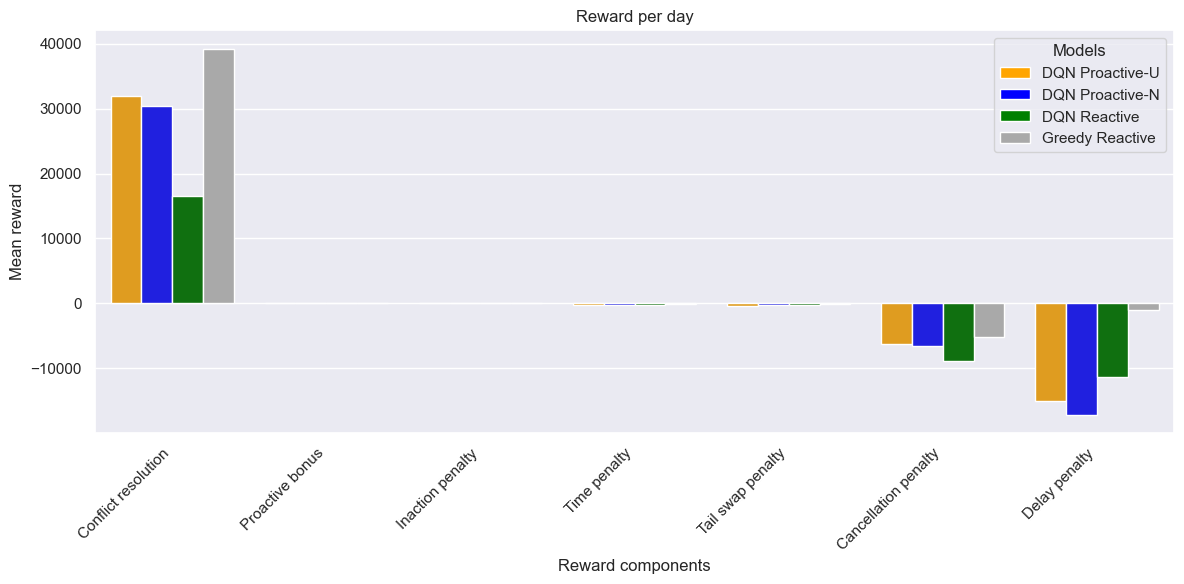

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define reward components and their display names
reward_components = [
    'Reward_delay_penalty_total', 
    'Reward_cancel_penalty', 
    'Reward_inaction_penalty', 
    'Reward_proactive_bonus', 
    'Reward_time_penalty', 
    'Reward_final_conflict_resolution_reward'
]

# Calculate tail swap reward from TailSwaps column
merged_df['Reward_tail_swaps'] = merged_df['TailSwaps'] * -100  # -100 per tail swap

# Add tail swaps to reward components
reward_components.append('Reward_tail_swaps')

component_display_names = {
    'Reward_delay_penalty_total': 'Delay penalty',
    'Reward_cancel_penalty': 'Cancellation penalty', 
    'Reward_inaction_penalty': 'Inaction penalty',
    'Reward_proactive_bonus': 'Proactive bonus',
    'Reward_time_penalty': 'Time penalty',
    'Reward_final_conflict_resolution_reward': 'Conflict resolution',
    'Reward_tail_swaps': 'Tail swap penalty'
}

model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Sort models to ensure correct order
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive', 'Greedy Proactive']
model_colors = {k: v for k, v in sorted(model_colors.items(), key=lambda x: model_order.index(x[1][1]))}

# Melt the DataFrame to reshape it for bar plotting
melted_df = merged_df.melt(
    id_vars=['Model'], 
    value_vars=reward_components,
    var_name='RewardComponent', 
    value_name='Reward'
)

# Map component names to display names
melted_df['RewardComponent'] = melted_df['RewardComponent'].map(component_display_names)

# Group by Model and RewardComponent to calculate the mean reward values
mean_rewards_df = melted_df.groupby(['Model', 'RewardComponent'], as_index=False).mean()

# Get the order of components based on Proactive-U values
proactive_u_values = mean_rewards_df[mean_rewards_df['Model'].str.contains('proactive', case=False) & 
                                   ~mean_rewards_df['Model'].str.contains('myopic', case=False)]
component_order = proactive_u_values.sort_values('Reward', ascending=False)['RewardComponent'].unique()

# Set figure size
plt.figure(figsize=(12, 6))

# Create custom legend handles
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color[0], label=color[1]) 
    for model, color in model_colors.items()
]

# Bar plot with custom colors and order
sns.barplot(
    data=mean_rewards_df,
    x='RewardComponent',
    y='Reward',
    hue='Model',
    hue_order=[k for k in model_colors.keys()],
    palette={model: color[0] for model, color in model_colors.items()},
    order=component_order
)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.xlabel("Reward components")
plt.ylabel("Mean reward")
plt.title("Reward per day")

# Remove the auto-generated legend and add custom colored legend
plt.gca().legend_.remove()
plt.legend(handles=legend_elements, title="Models")

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Slack
</br>
</br>
</br>
</div>

In [42]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd

# # Define a color map and human-readable labels for the models in specific order
# model_colors = {
#     'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
#     'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
#     'DQN Reactive': ('green', 'DQN Reactive'),
#     'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
# }

# # Define the metrics and corresponding y-axis labels in the specified order
# metrics = [
#     ("TotalCancelledFlights", "Cancelled flights"),
#     ("TotalDelays", "Delays (minutes)"),
#     ("TailSwaps", "Tail swaps")
# ]

# # Create slack buckets of size 0.05
# bucket_size = 0.05
# bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
# bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# # Create slack intervals using the defined buckets
# merged_df['SlackInterval'] = pd.cut(merged_df['ScenarioSlack'], 
#                                     bins=bucket_edges,
#                                     labels=bucket_labels,
#                                     include_lowest=True)

# # Print number of unique scenarios in each bucket
# print("Number of unique scenarios in each bucket:")
# for bucket in bucket_labels:
#     scenario_count = merged_df[merged_df['SlackInterval'] == bucket]['Scenario'].nunique()
#     print(f"Bucket {bucket}: {scenario_count} scenarios")

# # Aggregate data by taking the mean of the numeric metrics for each (Model, SlackInterval)
# agg_df = (
#     merged_df
#     .groupby(['Model', 'SlackInterval'], as_index=False)[[m[0] for m in metrics]]
#     .mean()
# )

# # Remove rows where SlackInterval has no actual values
# agg_df = agg_df.dropna(subset=['SlackInterval'])

# # Define the display range for slack values
# display_range = (0.3, 0.55)  # for example, only show intervals between 0.2 and 0.6

# # Filter agg_df to only include intervals that lie fully within display_range
# def interval_in_range(interval_label, low, high):
#     start_str, end_str = interval_label.split('-')
#     start_val = float(start_str)
#     end_val = float(end_str)
#     # Check if the entire interval lies within the specified range
#     return start_val >= low and end_val <= high

# agg_df = agg_df[agg_df['SlackInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# bar_width = 0.2  # Reduced to accommodate 4 bars

# # Get only the filtered slack intervals
# slack_intervals = sorted(agg_df['SlackInterval'].unique())
# x = np.arange(len(slack_intervals))

# # Plot each metric in a separate figure
# for i, (metric, ylabel) in enumerate(metrics):
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     # Plot bars for each model in specific order
#     model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
#     for j, desired_label in enumerate(model_order):
#         # Find the model name that corresponds to this label
#         matching_models = [name for name, (_, label) in model_colors.items() if label == desired_label]
#         if not matching_models:
#             continue
#         model_name = matching_models[0]
#         color = model_colors[model_name][0]
        
#         model_data = agg_df[agg_df['Model'] == model_name]
        
#         # Align model data with available slack intervals
#         model_values = [
#             model_data[model_data['SlackInterval'] == interval][metric].iloc[0]
#             if not model_data[model_data['SlackInterval'] == interval].empty 
#             else 0 
#             for interval in slack_intervals
#         ]
        
#         ax.bar(x + j*bar_width, 
#                model_values,
#                bar_width,
#                label=desired_label,
#                color=color,
#                alpha=0.9)
    
#     ax.set_xlabel("Scenario slack")
#     ax.set_ylabel(ylabel)
#     ax.set_title(f"Impact of schedule robustness on {ylabel.lower()}")
#     ax.set_xticks(x + bar_width*1.5)  # Centered between bars
#     ax.set_xticklabels(slack_intervals, rotation=45)
#     ax.grid(True, axis='y')
    
#     # Add legend
#     ax.legend(title="Model", frameon=True, ncol=2)
    
#     plt.tight_layout()
#     plt.show()



Linear Regression Results (using raw data):

Metric: Cancelled flights
  DQN Proactive-U: slope=-1.8856, p-value=0.000
  DQN Proactive-N: slope=-2.7962, p-value=0.000
  DQN Reactive: slope=-1.6316, p-value=0.000
  Greedy Reactive: slope=-1.6474, p-value=0.000

Metric: Delays (minutes)
  DQN Proactive-U: slope=-136.7149, p-value=0.000
  DQN Proactive-N: slope=-304.8501, p-value=0.000
  DQN Reactive: slope=-111.9766, p-value=0.000
  Greedy Reactive: slope=25.3842, p-value=0.001

Metric: Tail swaps
  DQN Proactive-U: slope=-1.8661, p-value=0.000
  DQN Proactive-N: slope=1.3856, p-value=0.000
  DQN Reactive: slope=-2.5112, p-value=0.000
  Greedy Reactive: slope=-0.2872, p-value=0.001


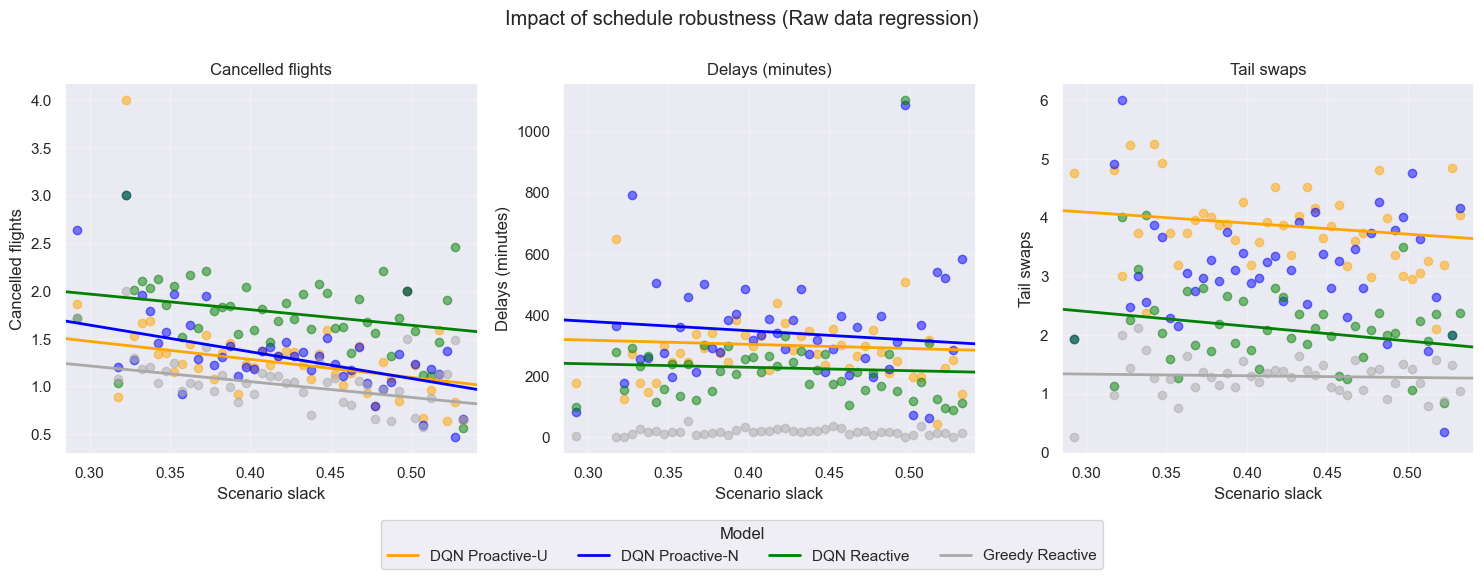

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Define a color map and human-readable labels for the models
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue',   'DQN Proactive-N'),
    'DQN Reactive':     ('green', 'DQN Reactive'),
    'Greedy Reactive':  ('darkgrey', 'Greedy Reactive')
}

# Define metrics
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays",          "Delays (minutes)"), 
    ("TailSwaps",            "Tail swaps")
]

# -------------------------
# 1) Create aggregated data for plotting points (just to reduce scatter clutter)
# Note: This bucketing is only used for the scatter plot visualization, not for the regression
# -------------------------
bucket_size = 0.005  # Bucket width for aggregated scatter points
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [
    f"{bucket_edges[i]:.3f}-{bucket_edges[i+1]:.3f}"
    for i in range(len(bucket_edges)-1)
]

merged_df['SlackInterval'] = pd.cut(
    merged_df['ScenarioSlack'],
    bins=bucket_edges,
    labels=bucket_labels,
    include_lowest=True,
    ordered=False
)

# Aggregate data by taking the mean of the numeric metrics
agg_df = (
    merged_df
    .groupby(['Model', 'SlackInterval'], as_index=False, observed=True)
    [[m[0] for m in metrics]]
    .mean()
)

# Remove rows where SlackInterval is NaN
agg_df = agg_df.dropna(subset=['SlackInterval'])

# Function to get the midpoint from the SlackInterval label
def interval_midpoint(interval_label):
    start_str, end_str = interval_label.split('-')
    return 0.5 * (float(start_str) + float(end_str))

# Add a midpoint for plotting scatter
agg_df['SlackMidpoint'] = agg_df['SlackInterval'].apply(interval_midpoint)

# -------------------------
# 2) Prepare figure
# -------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Note: Linear regression is performed on raw data points, not on bucketed data
print("\nLinear Regression Results (using raw data):")

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    print(f"\nMetric: {ylabel}")
    
    # We'll track the min and max slack for this subplot
    all_slacks_for_metric = []
    
    for desired_label in model_order:
        # Get the internal key (e.g., 'DQN Proactive-U') from the dict
        matching_models = [
            k for k, v in model_colors.items() if v[1] == desired_label
        ]
        if not matching_models:
            continue
        model_key = matching_models[0]
        color = model_colors[model_key][0]
        
        # -------------------------
        # A) Compute linear regression using raw data points (not bucketed)
        # -------------------------
        df_model = merged_df[merged_df['Model'] == model_key].copy()
        # Keep valid rows
        df_model = df_model.dropna(subset=['ScenarioSlack', metric])
        if len(df_model) < 2:
            continue
        
        # Raw x and y (using individual data points, not bucketed)
        X_raw = df_model['ScenarioSlack']
        y_raw = df_model[metric]
        
        # Keep track of these Slack values
        all_slacks_for_metric.extend(X_raw.tolist())
        
        # Add constant term for intercept
        X_raw = sm.add_constant(X_raw)
        
        # Fit OLS model
        model = sm.OLS(y_raw, X_raw).fit()
        slope = model.params.iloc[1]  # Use iloc instead of positional indexing
        intercept = model.params.iloc[0]
        p_value = model.pvalues.iloc[1]  # p-value for the slope coefficient
        
        print(f"  {desired_label}: slope={slope:.4f}, p-value={p_value:.3f}")
        
        # -------------------------
        # B) Plot bucketed points for scatter visualization only
        # -------------------------
        df_agg_model = agg_df[agg_df['Model'] == model_key]
        x_vals = df_agg_model['SlackMidpoint'].values
        y_vals = df_agg_model[metric].values
        
        ax.scatter(x_vals, y_vals, color=color, alpha=0.5)
    
    # After looping over all models, we know the min & max Slack for this metric
    if len(all_slacks_for_metric) > 0:
        min_slack = min(all_slacks_for_metric)
        max_slack = max(all_slacks_for_metric)
        
        # Add a small margin to avoid points being on the very edge
        margin = 0.01
        slack_left = max(0, min_slack - margin)
        slack_right = min(1, max_slack + margin)
        
        # Now, re-loop to plot the regression lines using the updated x-range
        for desired_label in model_order:
            matching_models = [
                k for k, v in model_colors.items() if v[1] == desired_label
            ]
            if not matching_models:
                continue
            model_key = matching_models[0]
            color = model_colors[model_key][0]
            
            # Raw data for regression (not bucketed)
            df_model = merged_df[merged_df['Model'] == model_key].copy()
            df_model = df_model.dropna(subset=['ScenarioSlack', metric])
            if len(df_model) < 2:
                continue
            
            X_raw = df_model['ScenarioSlack']
            y_raw = df_model[metric]
            X_raw = sm.add_constant(X_raw)
            model = sm.OLS(y_raw, X_raw).fit()
            
            # Only plot if slope is negative and p-value < 0.05
            if model.params.iloc[1] < 0 and model.pvalues.iloc[1] < 0.05:
                # Create a denser grid within [slack_left, slack_right]
                x_grid = np.linspace(slack_left, slack_right, 100)
                X_grid = sm.add_constant(x_grid)
                y_pred_line = model.predict(X_grid)
                
                # Plot the regression line
                ax.plot(x_grid, y_pred_line, color=color, linewidth=2, label=desired_label)
        
        # Finally, set the x-limits to the data range
        ax.set_xlim(slack_left, slack_right)
    
    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True, alpha=0.3)

# Create a global legend (need to deduplicate labels)
handles, labels = axes[0].get_legend_handles_labels()
unique_pairs = list(dict(zip(labels, handles)).items())
labels_unique, handles_unique = zip(*unique_pairs)

fig.legend(
    handles_unique, labels_unique,
    loc='center', bbox_to_anchor=(0.5, -0.05),
    ncol=4, title="Model", frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of schedule robustness (Raw data regression)", y=1.02)
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Impact of # disrupted flights
</br>
</br>
</br>
</div>

In [44]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from scipy import stats

# # Define a color map and human-readable labels for the models in specific order
# model_colors = {
#     'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
#     'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
#     'DQN Reactive': ('green', 'DQN Reactive'),
#     'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
# }

# # Define the metrics and corresponding y-axis labels in specified order
# metrics = [
#     ("TotalCancelledFlights", "Cancelled flights"),
#     ("TotalDelays", "Delays (minutes)"),
#     ("TailSwaps", "Tail swaps")
# ]

# # Print scenarios with 0 disrupted flights but non-zero cancellations for reactive models
# print("\nScenarios with 0 disrupted flights but non-zero cancellations:")
# for model in ['DQN Reactive', 'Greedy Reactive']:
#     scenarios = merged_df[
#         (merged_df['Model'] == model) & 
#         (merged_df['ActualDisruptedFlights'] == 0) & 
#         (merged_df['TotalCancelledFlights'] > 0)
#     ]['Scenario'].unique()
#     if len(scenarios) > 0:
#         print(f"\n{model}:")
#         for scenario in scenarios:
#             print(f"Scenario: {scenario}")

# # Print scenarios with 0 disrupted flights but non-zero cancellations for reactive models
# print("\nScenarios with 0 disrupted flights but non-zero tail swaps:")
# for model in ['DQN Reactive', 'Greedy Reactive']:
#     scenarios = merged_df[
#         (merged_df['Model'] == model) & 
#         (merged_df['ActualDisruptedFlights'] == 0) & 
#         (merged_df['TailSwaps'] > 0)
#     ]['Scenario'].unique()
#     if len(scenarios) > 0:
#         print(f"\n{model}:")
#         for scenario in scenarios:
#             print(f"Scenario: {scenario}")

# # Print number of unique scenarios per disrupted flights bucket
# print("\nNumber of unique scenarios per disrupted flights bucket:")
# scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
# for n_disrupted, n_scenarios in scenario_counts.items():
#     print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# # Aggregate data by taking the mean of the numeric metrics for each (Model, ActualDisruptedFlights)
# agg_df = (
#     merged_df
#     .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
#     .mean()
# )

# # Create a figure with 3 subplots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# for i, (metric, ylabel) in enumerate(metrics):
#     ax = axes[i]
    
#     # Calculate number of models and adjust bar width and spacing
#     n_models = len(model_colors)
#     bar_width = 0.15  # Reduced bar width to accommodate 4 bars
#     total_width = bar_width * n_models
#     start_offset = -total_width/2 + bar_width/2  # Center the group of bars
    
#     print(f"\nSlopes for {ylabel}:")
#     slopes = []
    
#     # Plot bars for each model in the specified order
#     bar_offset = start_offset
#     for model_name, (color, label) in model_colors.items():
#         model_data = agg_df[agg_df['Model'] == model_name].copy()
#         # Sort by ActualDisruptedFlights
#         model_data = model_data.sort_values(by='ActualDisruptedFlights')
        
#         x = model_data['ActualDisruptedFlights']
#         y = model_data[metric]
            
#         ax.bar(
#             x + bar_offset,  # Offset bars
#             y,
#             width=bar_width,
#             label=label,
#             color=color,
#             alpha=0.9
#         )
        
#         # Add linear regression
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#         slopes.append(slope)
#         line_x = np.array([min(x), max(x)])
#         line_y = slope * line_x + intercept
#         ax.plot(line_x + bar_offset, line_y, '--', color=color, alpha=0.5)
        
#         print(f"{label}: {slope:.2f} per disrupted flight")
        
#         bar_offset += bar_width  # Move to next position
    
#     print(f"Average slope: {np.mean(slopes):.2f} per disrupted flight")

#     ax.set_xlabel("Number of disrupted flights")
#     ax.set_ylabel(ylabel)
#     ax.set_title(ylabel)
#     ax.grid(True, axis='y')

# # Add a global legend (once for all subplots)
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Model", frameon=True)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle("Impact of number of disrupted flights", y=1.02)
# plt.show()



Distribution of scenarios by number of disrupted flights:
Disrupted flights = 0: 43725 rows (15.6%)
Disrupted flights = 1: 38980 rows (13.9%)
Disrupted flights = 2: 74863 rows (26.7%)
Disrupted flights = 3: 62417 rows (22.3%)
Disrupted flights = 4: 42423 rows (15.2%)
Disrupted flights = 5: 15650 rows (5.6%)
Disrupted flights = 6: 1942 rows (0.7%)

Distribution of scenarios by number of disrupted flights (DQN Proactive-N only):
Disrupted flights = 0: 10870 rows (15.5%)
Disrupted flights = 1: 9770 rows (14.0%)
Disrupted flights = 2: 18826 rows (26.9%)
Disrupted flights = 3: 15516 rows (22.2%)
Disrupted flights = 4: 10564 rows (15.1%)
Disrupted flights = 5: 3953 rows (5.6%)
Disrupted flights = 6: 501 rows (0.7%)

Scenarios with 0 disrupted flights but non-zero cancellations:

Scenarios with 0 disrupted flights but non-zero tail swaps:

DQN Reactive:
Scenario: stochastic_high_Scenario_089
Scenario: mixed_low_Scenario_014
Scenario: mixed_medium_Scenario_057
Scenario: stochastic_high_Scenar

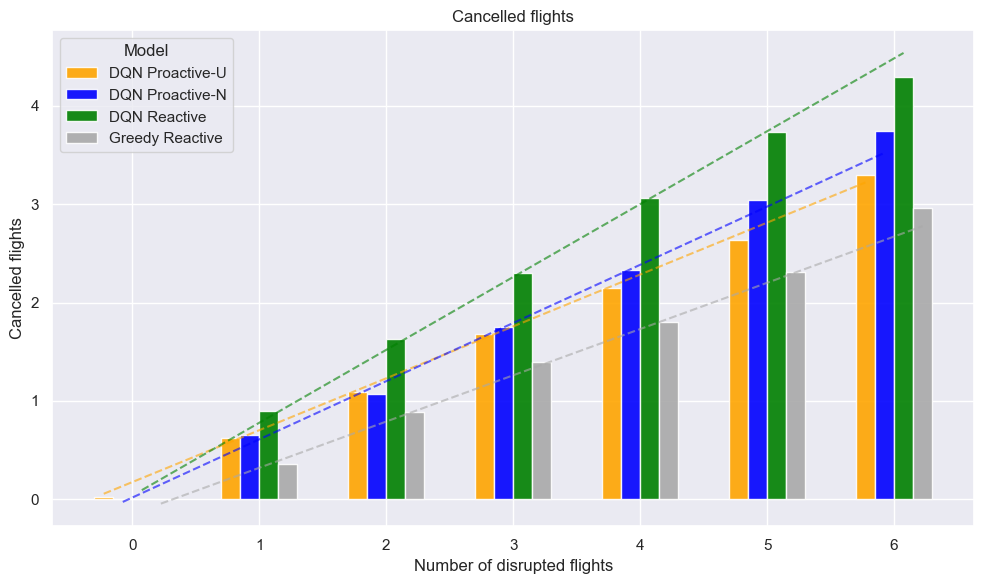


Slopes for Delays (minutes) (raw data regressions):
 DQN Proactive-U: slope=38.59, intercept=213.55, p=0.0000, R²=0.031, n=70000
 DQN Proactive-N: slope=81.98, intercept=156.83, p=0.0000, R²=0.083, n=70000
 DQN Reactive: slope=81.62, intercept=40.76, p=0.0000, R²=0.141, n=70000
 Greedy Reactive: slope=9.73, intercept=-2.49, p=0.0000, R²=0.032, n=70000
 Average slope: 52.98 per disrupted flight


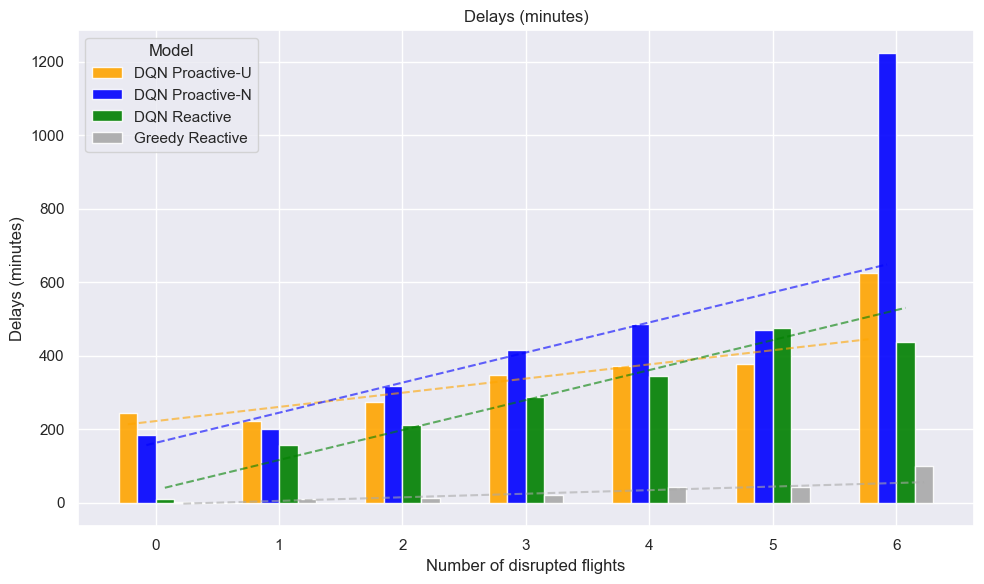


Slopes for Tail swaps (raw data regressions):
 DQN Proactive-U: slope=0.45, intercept=2.86, p=0.0000, R²=0.108, n=70000
 DQN Proactive-N: slope=0.65, intercept=1.67, p=0.0000, R²=0.208, n=70000
 DQN Reactive: slope=0.77, intercept=0.35, p=0.0000, R²=0.360, n=70000
 Greedy Reactive: slope=0.50, intercept=0.16, p=0.0000, R²=0.593, n=70000
 Average slope: 0.59 per disrupted flight


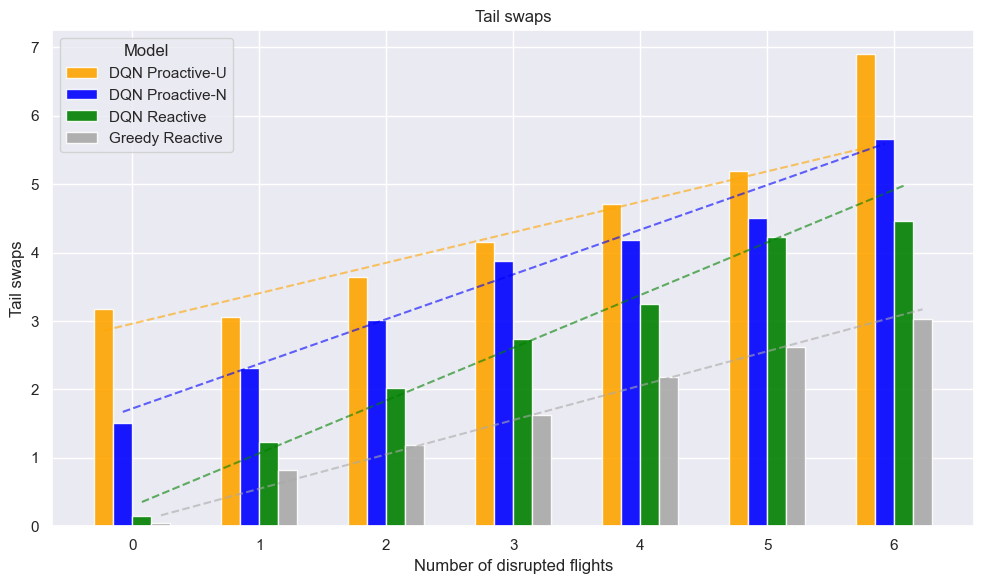

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm   # we'll use statsmodels for OLS
# or from scipy import stats   # either is fine

# Print distribution of scenarios across number of disrupted flights
print("\nDistribution of scenarios by number of disrupted flights:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].count()
for n_disrupted, count in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {count} rows ({count/len(merged_df)*100:.1f}%)")

# Print distribution of scenarios across number of disrupted flights for DQN Proactive-N
print("\nDistribution of scenarios by number of disrupted flights (DQN Proactive-N only):")
proactive_n_df = merged_df[merged_df['Model'] == 'DQN Proactive-N']
scenario_counts = proactive_n_df.groupby('ActualDisruptedFlights')['Scenario'].count()
for n_disrupted, count in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {count} rows ({count/len(proactive_n_df)*100:.1f}%)")

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"), 
    ("TailSwaps", "Tail swaps")
]

# ------------------------------------------------------------------
# 0) Just some diagnostic prints (as in your original code)
# ------------------------------------------------------------------
print("\nScenarios with 0 disrupted flights but non-zero cancellations:")
for model in ['DQN Reactive', 'Greedy Reactive']:
    scenarios = merged_df[
        (merged_df['Model'] == model) & 
        (merged_df['ActualDisruptedFlights'] == 0) & 
        (merged_df['TotalCancelledFlights'] > 0)
    ]['Scenario'].unique()
    if len(scenarios) > 0:
        print(f"\n{model}:")
        for scenario in scenarios:
            print(f"Scenario: {scenario}")

print("\nScenarios with 0 disrupted flights but non-zero tail swaps:")
for model in ['DQN Reactive', 'Greedy Reactive']:
    scenarios = merged_df[
        (merged_df['Model'] == model) & 
        (merged_df['ActualDisruptedFlights'] == 0) & 
        (merged_df['TailSwaps'] > 0)
    ]['Scenario'].unique()
    if len(scenarios) > 0:
        print(f"\n{model}:")
        for scenario in scenarios:
            print(f"Scenario: {scenario}")

print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# ------------------------------------------------------------------
# 1) Aggregate data by (Model, ActualDisruptedFlights) for bar chart
# ------------------------------------------------------------------
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# ------------------------------------------------------------------
# 2) Function to compute slope/intercept using *raw data*
#    for one model & one metric
# ------------------------------------------------------------------
def get_raw_regression_params(df, model_name, metric):
    """
    Returns (slope, intercept, n_points, p_value, r_squared)
    from a linear regression of metric ~ ActualDisruptedFlights (raw).
    """
    # Filter raw rows for that model
    df_model = df[(df['Model'] == model_name)].copy()
    df_model = df_model.dropna(subset=['ActualDisruptedFlights', metric])
    if len(df_model) < 2:
        return None, None, 0, None, None
    
    x_raw = df_model['ActualDisruptedFlights'].values
    y_raw = df_model[metric].values
    
    # Fit OLS
    import statsmodels.api as sm
    X_ols = sm.add_constant(x_raw)  # shape (n, 2) => columns: [const, x_raw]
    ols_model = sm.OLS(y_raw, X_ols).fit()
    
    # Option A) by position
    intercept = ols_model.params[0]  # 'const'
    slope     = ols_model.params[1]  # the next column
    
    # Optionally, get p-value and R^2
    p_value = ols_model.pvalues[1]    # for slope
    r_sq    = ols_model.rsquared
    n_points = len(df_model)
    
    return slope, intercept, n_points, p_value, r_sq


# ------------------------------------------------------------------
# 3) Create bar chart + plot raw-data regression lines
# ------------------------------------------------------------------
for metric, ylabel in metrics:
    plt.figure(figsize=(10, 6))
    
    # We'll get a sorted list of unique disrupted-flight counts
    # for the final x-axis.
    all_disrupted = sorted(agg_df['ActualDisruptedFlights'].unique())
    
    # Calculate number of models and adjust bar width and spacing
    n_models = len(model_colors)
    bar_width = 0.15
    total_width = bar_width * n_models
    start_offset = -total_width / 2 + bar_width / 2  # to center groups of bars
    
    print(f"\nSlopes for {ylabel} (raw data regressions):")
    slopes = []
    
    bar_offset = start_offset
    for model_name, (color, label) in model_colors.items():
        # Get aggregated y-values for bar chart
        model_data_agg = agg_df[agg_df['Model'] == model_name].copy()
        model_data_agg = model_data_agg.sort_values(by='ActualDisruptedFlights')
        
        x_bar = model_data_agg['ActualDisruptedFlights'].values
        y_bar = model_data_agg[metric].values
        
        # Plot the bars
        plt.bar(
            x_bar + bar_offset,
            y_bar,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.9
        )
        
        # ------------------------------
        # 3A) Get slope & intercept from RAW data
        # ------------------------------
        slope, intercept, n_points, p_val, r_sq = get_raw_regression_params(merged_df, model_name, metric)
        if slope is not None:
            # We'll store slope just for printing an "average slope"
            slopes.append(slope)
            
            # Only plot regression line if p < 0.05
            if p_val < 0.05:
                # Create a line from min(x_bar) to max(x_bar), or from the entire set
                x_line = np.array([min(all_disrupted), max(all_disrupted)])
                # Predicted y
                y_line = intercept + slope * x_line
                
                # Plot the regression line slightly offset so it goes above the bars
                plt.plot(x_line + bar_offset, y_line, '--', color=color, alpha=0.6)
            
            print(f" {label}: slope={slope:.2f}, intercept={intercept:.2f}, "
                  f"p={p_val:.4f}, R²={r_sq:.3f}, n={n_points}")
        else:
            print(f" {label}: Not enough data to do regression.")
        
        bar_offset += bar_width
    
    if len(slopes) > 0:
        print(f" Average slope: {np.mean(slopes):.2f} per disrupted flight")

    # ------------------------------
    # 3B) Final labeling
    # ------------------------------
    plt.xlabel("Number of disrupted flights")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.grid(True, axis='y')
    plt.legend(title="Model", frameon=True)
    plt.tight_layout()
    plt.show()



Number of unique scenarios per disrupted flights bucket:
Disrupted flights = 0: 323 scenarios
Disrupted flights = 1: 265 scenarios
Disrupted flights = 2: 457 scenarios
Disrupted flights = 3: 348 scenarios
Disrupted flights = 4: 217 scenarios
Disrupted flights = 5: 82 scenarios
Disrupted flights = 6: 12 scenarios


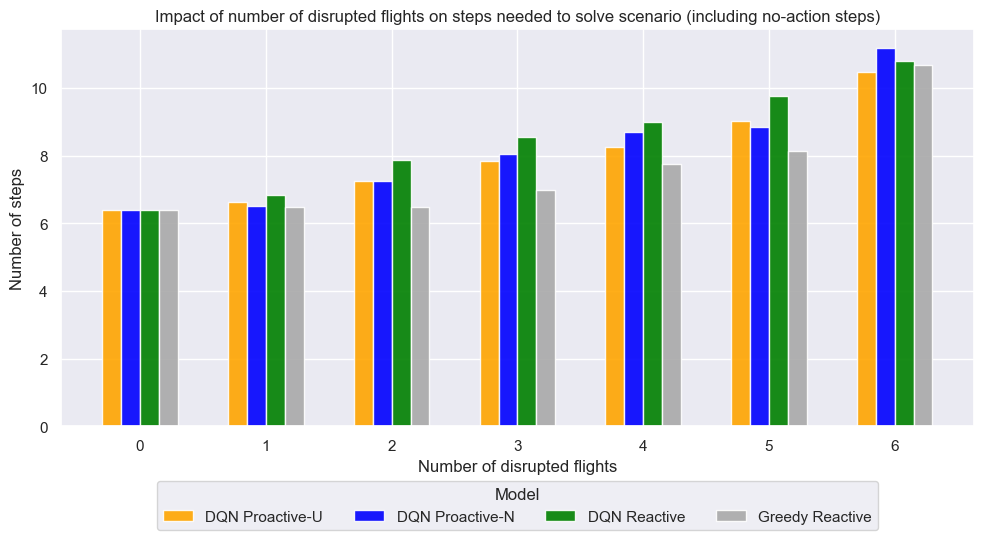

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Print number of unique scenarios per disrupted flights bucket
print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# Aggregate data by taking the mean of ScenarioSteps for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[['ScenarioSteps']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(10, 6))

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.15  # Reduced bar width to accommodate 4 bars
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = agg_df[agg_df['Model'] == model_name].copy()
    # Sort by ActualDisruptedFlights
    model_data = model_data.sort_values(by='ActualDisruptedFlights')
    
    x = model_data['ActualDisruptedFlights']
    y = model_data['ScenarioSteps']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Number of disrupted flights")
plt.ylabel("Number of steps")
plt.title("Impact of number of disrupted flights on steps needed to solve scenario (including no-action steps)")
plt.grid(True, axis='y')

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Number of unique scenarios with 0 disrupted flights: 323
Number of unique scenarios with 1 disrupted flights: 265
Number of unique scenarios with 2 disrupted flights: 457
Number of unique scenarios with 3 disrupted flights: 348
Number of unique scenarios with 4 disrupted flights: 217
Number of unique scenarios with 5 disrupted flights: 82
Number of unique scenarios with 6 disrupted flights: 12


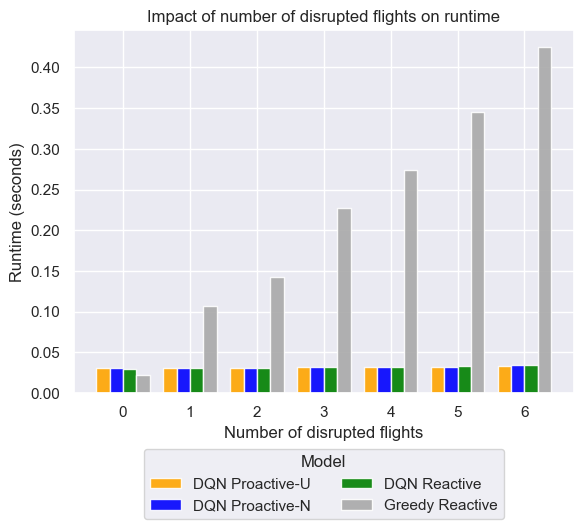

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Print number of unique scenarios for each disrupted flights bucket
for n_disrupted in sorted(merged_df['ActualDisruptedFlights'].unique()):
    n_scenarios = len(merged_df[merged_df['ActualDisruptedFlights'] == n_disrupted]['Scenario'].unique())
    print(f"Number of unique scenarios with {n_disrupted} disrupted flights: {n_scenarios}")

# Aggregate data by taking the mean runtime for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(6, 6))

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.2  # Width of each bar
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = agg_df[agg_df['Model'] == model_name].copy()
    # Sort by ActualDisruptedFlights
    model_data = model_data.sort_values(by='ActualDisruptedFlights')
    
    x = model_data['ActualDisruptedFlights']
    y = model_data['ScenarioTime']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Number of disrupted flights")
plt.ylabel("Runtime (seconds)")
plt.title("Impact of number of disrupted flights on runtime")
plt.grid(True, axis='y')

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=2, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Impact of scenario size
</br>
</br>
</br>
</div>

Flight count statistics:
# scenarios with 12 flights: 20
# scenarios with 13 flights: 47
# scenarios with 14 flights: 83
# scenarios with 15 flights: 132
# scenarios with 16 flights: 112
# scenarios with 17 flights: 117
# scenarios with 18 flights: 100
# scenarios with 19 flights: 52
# scenarios with 20 flights: 24
# scenarios with 21 flights: 7


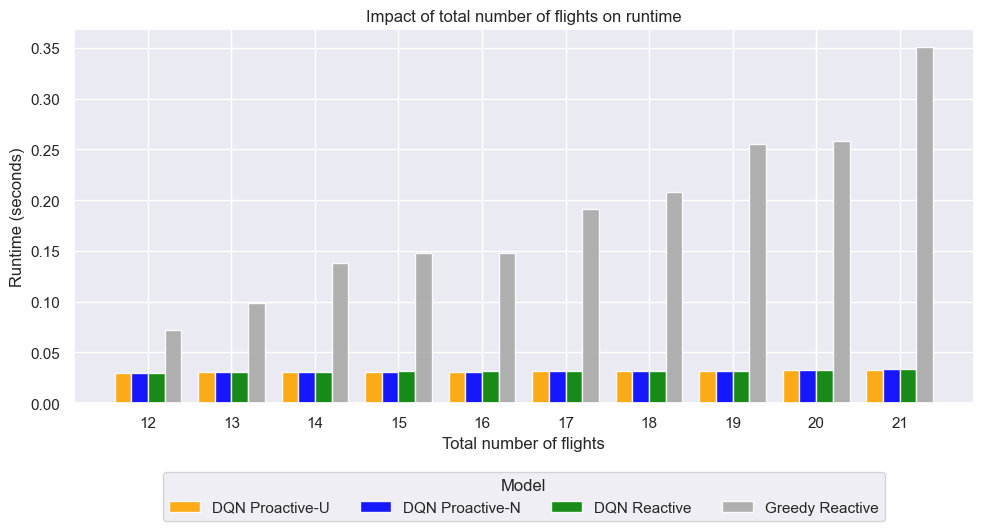

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the range of total flights to plot
min_flights = 12
max_flights = 21

# Filter data for the specified range
filtered_df = merged_df[
    (merged_df['TotalFlights'] >= min_flights) & 
    (merged_df['TotalFlights'] <= max_flights)
]

# Get all unique flight counts and their scenarios within range
flight_counts = filtered_df['TotalFlights'].unique()
flight_counts.sort()

print("Flight count statistics:")
for num_flights in flight_counts:
    scenarios = filtered_df[filtered_df['TotalFlights'] == num_flights]['Scenario'].unique()
    print(f"# scenarios with {num_flights} flights: {len(scenarios)}")

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Aggregate data by taking the mean runtime for each (Model, TotalFlights)
agg_df = (
    filtered_df
    .groupby(['Model', 'TotalFlights'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Rename columns for clarity in CSV
agg_df_for_csv = agg_df.rename(columns={
    'Model': 'model_name',
    'TotalFlights': 'total_number_of_flights',
    'ScenarioTime': 'average_runtime_seconds'
})

# Save aggregated results to CSV with descriptive column names
agg_df_for_csv.to_csv('runtime_analysis_by_total_flights.csv', 
                      index=False,
                      float_format='%.3f')  # Format floats to 3 decimal places

# Create a single figure
plt.figure(figsize=(10, 6))

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.2  # Width of each bar
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = agg_df[agg_df['Model'] == model_name].copy()
    # Sort by TotalFlights
    model_data = model_data.sort_values(by='TotalFlights')
    
    x = model_data['TotalFlights']
    y = model_data['ScenarioTime']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Total number of flights")
plt.ylabel("Runtime (seconds)")
plt.title("Impact of total number of flights on runtime")
plt.grid(True, axis='y')

# Set x-ticks for every number of flights
plt.xticks(np.arange(min_flights, max_flights + 1, 1))

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Number of unique scenarios per bucket:
2385-2585 min: 11 scenarios
2585-2785 min: 44 scenarios
2785-2985 min: 87 scenarios
2985-3185 min: 118 scenarios
3185-3385 min: 134 scenarios
3385-3585 min: 125 scenarios
3585-3785 min: 112 scenarios
3785-3985 min: 50 scenarios
3985-4185 min: 16 scenarios
4185-4385 min: 2 scenarios


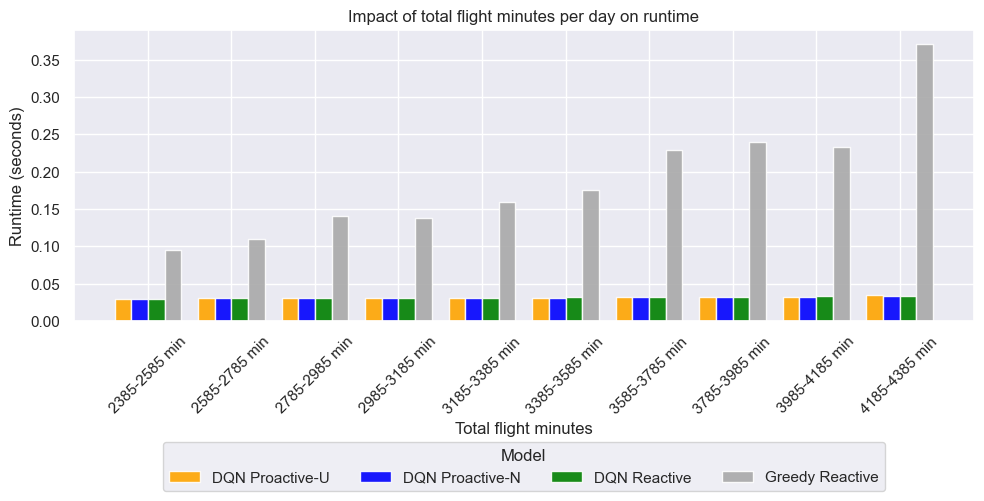

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}


# Calculate min and max flight minutes
min_minutes = merged_df['TotalFlightMinutes'].min()
max_minutes = merged_df['TotalFlightMinutes'].max()

# Create 4 equal-sized buckets of 30 minutes each
bucket_size = 200
bucket_edges = np.arange(min_minutes, max_minutes + bucket_size, bucket_size)

# Create bucket labels
bucket_labels = [
    f"{int(bucket_edges[i])}-{int(bucket_edges[i+1])} min" 
    for i in range(len(bucket_edges)-1)
]

# Add bucket column to merged_df
merged_df['Bucket'] = pd.cut(merged_df['TotalFlightMinutes'], 
                         bins=bucket_edges,
                         labels=bucket_labels)

# Print number of unique scenarios per bucket
print("Number of unique scenarios per bucket:")
for bucket in bucket_labels:
    n_scenarios = merged_df[merged_df['Bucket'] == bucket]['Scenario'].nunique()
    print(f"{bucket}: {n_scenarios} scenarios")

# Aggregate data by taking the mean runtime for each (Model, TotalFlightMinutes)
agg_df = (
    merged_df
    .groupby(['Model', 'TotalFlightMinutes'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Add bucket column to aggregated data
agg_df['Bucket'] = pd.cut(agg_df['TotalFlightMinutes'], 
                         bins=bucket_edges,
                         labels=bucket_labels)

# Further aggregate by buckets
bucket_agg_df = (
    agg_df
    .groupby(['Model', 'Bucket'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(10, 8))  # Increased height from 6 to 8

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.2  # Width of each bar
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = bucket_agg_df[bucket_agg_df['Model'] == model_name].copy()
    # Sort by bucket
    model_data = model_data.sort_values(by='Bucket')
    
    x = np.arange(len(model_data['Bucket']))
    y = model_data['ScenarioTime']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Total flight minutes")
plt.ylabel("Runtime (seconds)")
plt.title("Impact of total flight minutes per day on runtime")
plt.grid(True, axis='y')

# Set x-ticks to bucket labels
plt.xticks(np.arange(len(bucket_labels)), bucket_labels, rotation=45)

# Add legend with more space below
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.5), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted bottom margin to accommodate legend
plt.show()


<div class="alert alert-block alert-warning">
</br>
</br>
<b>TO DO: </b>Impact of probability on delays & cancellations in stochastic scenarios
</br>
</br>
</br>
</div>

Number of unique scenarios in each bucket:
Bucket 0.00-0.05: 0 scenarios
Bucket 0.05-0.10: 0 scenarios
Bucket 0.10-0.15: 2 scenarios
Bucket 0.15-0.20: 11 scenarios
Bucket 0.20-0.25: 17 scenarios
Bucket 0.25-0.30: 13 scenarios
Bucket 0.30-0.35: 34 scenarios
Bucket 0.35-0.40: 31 scenarios
Bucket 0.40-0.45: 27 scenarios
Bucket 0.45-0.50: 20 scenarios
Bucket 0.50-0.55: 18 scenarios
Bucket 0.55-0.60: 22 scenarios
Bucket 0.60-0.65: 28 scenarios
Bucket 0.65-0.70: 29 scenarios
Bucket 0.70-0.75: 21 scenarios
Bucket 0.75-0.80: 17 scenarios
Bucket 0.80-0.85: 6 scenarios
Bucket 0.85-0.90: 4 scenarios
Bucket 0.90-0.95: 0 scenarios
Bucket 0.95-1.00: 0 scenarios


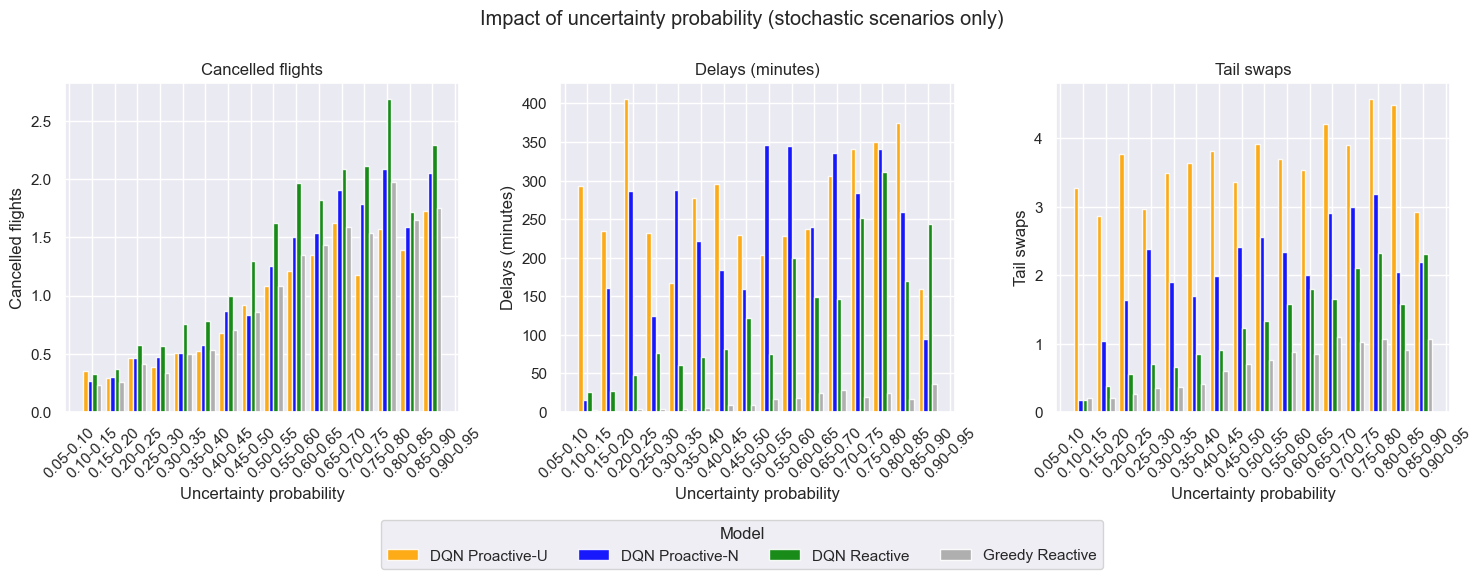

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}
# Define the metrics and corresponding y-axis labels in the specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Create a filtered copy for stochastic scenarios only
filtered_df = merged_df[merged_df['Scenario'].str.contains('stochastic', case=False)].copy()

# Create probability buckets of size 0.05
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create probability intervals using the defined buckets
filtered_df['ProbabilityInterval'] = pd.cut(filtered_df['AvgUncertaintyProbability'], 
                                    bins=bucket_edges,
                                    labels=bucket_labels,
                                    include_lowest=True)

# Print number of unique scenarios in each bucket
print("Number of unique scenarios in each bucket:")
for bucket in bucket_labels:
    scenario_count = filtered_df[filtered_df['ProbabilityInterval'] == bucket]['Scenario'].nunique()
    print(f"Bucket {bucket}: {scenario_count} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, ProbabilityInterval)
agg_df = (
    filtered_df
    .groupby(['Model', 'ProbabilityInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where ProbabilityInterval has no actual values
agg_df = agg_df.dropna(subset=['ProbabilityInterval'])

# Define the display range for probability values
display_range = (0.05, 0.95)  # for example, only show intervals between 0.2 and 0.6

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    # Check if the entire interval lies within the specified range
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['ProbabilityInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

bar_width = 0.2  # Reduced to accommodate 4 bars

# Get only the filtered probability intervals
probability_intervals = sorted(agg_df['ProbabilityInterval'].unique())
x = np.arange(len(probability_intervals))

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in specific order
    model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
    for j, desired_label in enumerate(model_order):
        # Find the model name that corresponds to this label
        matching_models = [name for name, (_, label) in model_colors.items() if label == desired_label]
        if not matching_models:
            continue
        model_name = matching_models[0]
        color = model_colors[model_name][0]
        
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available probability intervals
        model_values = [
            model_data[model_data['ProbabilityInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['ProbabilityInterval'] == interval].empty 
            else 0 
            for interval in probability_intervals
        ]
        
        ax.bar(x + j*bar_width, 
               model_values,
               bar_width,
               label=desired_label,
               color=color,
               alpha=0.9)
    
    ax.set_xlabel("Uncertainty probability")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x + bar_width*1.5)  # Centered between bars
    ax.set_xticklabels(probability_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of uncertainty probability (stochastic scenarios only)", y=1.02)
plt.show()



=== Cancelled flights ===
  OLS (raw data) => intercept=0.2233, slope_per_1pct=-0.0080
  p-value=0.000100, R^2=0.0496, n=300


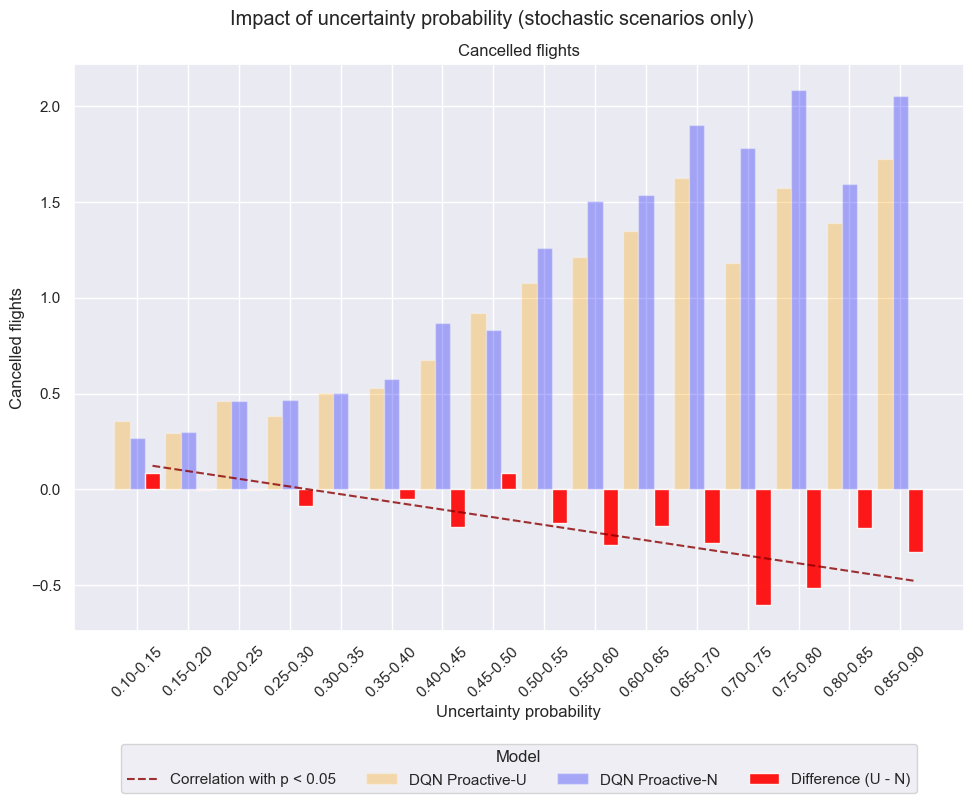


=== Delays (minutes) ===
  OLS (raw data) => intercept=49.5821, slope_per_1pct=-0.7904
  p-value=0.550234, R^2=0.0012, n=300


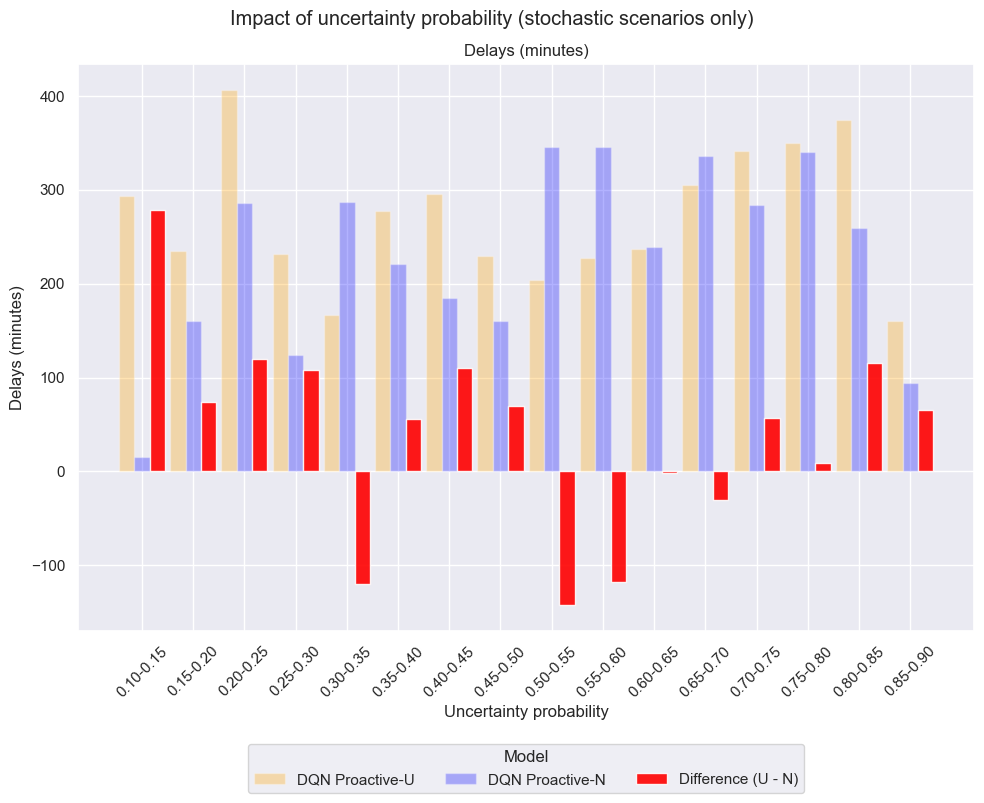


=== Tail swaps ===
  OLS (raw data) => intercept=1.9680, slope_per_1pct=-0.0095
  p-value=0.121428, R^2=0.0080, n=300


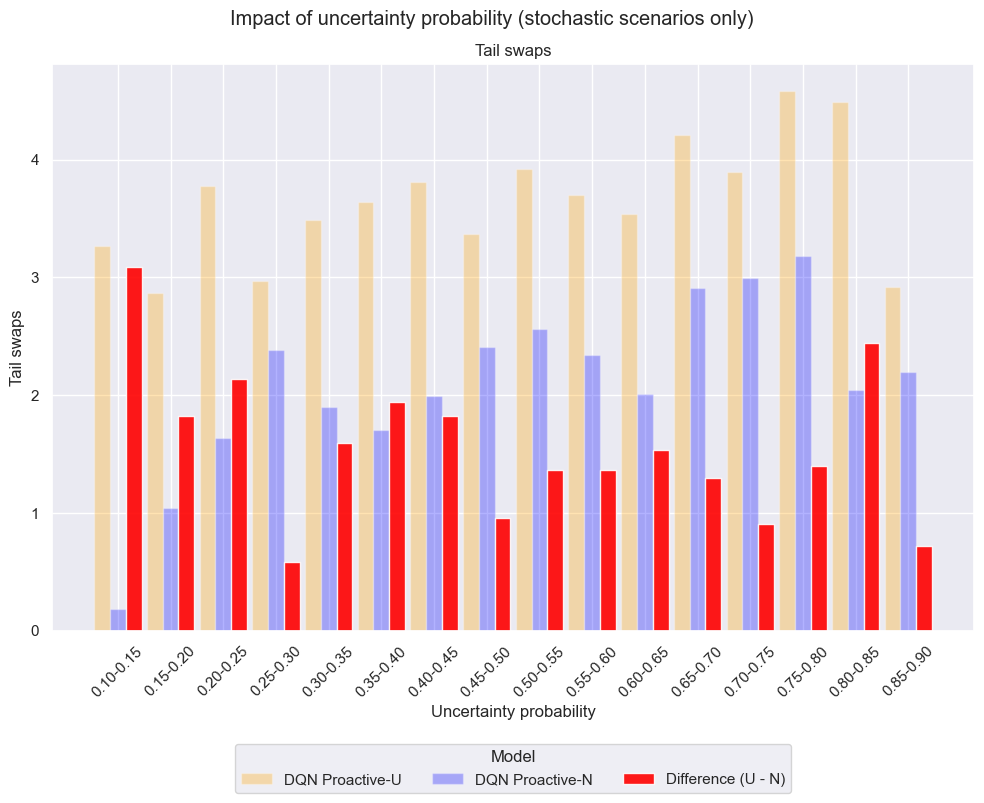

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ----------------------------------------------------
# 0) Pre-Filtering: Stochastic only, two proactive models
#    (similar to the logic in your Appendix 2)
# ----------------------------------------------------
df_stoch = merged_df[ merged_df['Scenario'].str.contains('stochastic', case=False) ].copy()

model_pair = ['DQN Proactive-U', 'DQN Proactive-N']
df_stoch = df_stoch[df_stoch['Model'].isin(model_pair)].copy()

metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# ----------------------------------------------------
# 1) Create a function to get slope/intercept from RAW data
#    using statsmodels (matching your Appendix 2 approach).
# ----------------------------------------------------
def get_diff_regression_params(df_stochastic, metric):
    """
    Returns:
      intercept, slope, p_value, r_squared, n
    from difference(U - N) ~ Probability * 100
    using the scenario-level raw data approach.
    """
    # Pivot so we have columns for U and N side by side
    df_pivot = (
        df_stochastic
        .pivot_table(index='Scenario',
                     columns='Model',
                     values=[metric, 'AvgUncertaintyProbability'],
                     aggfunc='mean')
        .reset_index()
    )
    # Flatten columns
    df_pivot.columns = [f"{col[0]}_{col[1]}" for col in df_pivot.columns]

    # Drop rows with missing data
    df_pivot.dropna(inplace=True)

    # For convenience, pick the 'U' probability column as the scenario probability
    prob_col_U = f"AvgUncertaintyProbability_{model_pair[0]}"
    metric_U = f"{metric}_{model_pair[0]}"
    metric_N = f"{metric}_{model_pair[1]}"

    # Compute difference = U - N
    df_pivot['Diff'] = df_pivot[metric_U] - df_pivot[metric_N]

    # X = Probability * 100
    df_pivot['ProbPercent'] = df_pivot[prob_col_U] * 100.0

    # Fit OLS: Diff ~ ProbPercent
    X = sm.add_constant(df_pivot['ProbPercent'])
    y = df_pivot['Diff']
    model = sm.OLS(y, X).fit()

    intercept = model.params['const']
    slope = model.params['ProbPercent']
    p_val = model.pvalues['ProbPercent']
    r_sq = model.rsquared
    n_points = len(df_pivot)

    return intercept, slope, p_val, r_sq, n_points

# ----------------------------------------------------
# 2) Now build the bar chart code (like Appendix 1),
#    but *replace* the diff line regression with the
#    RAW data slope & intercept from above function.
# ----------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue',   'DQN Proactive-N'),
    'DQN Reactive':     ('green', 'DQN Reactive'),
    'Greedy Reactive':  ('darkgrey', 'Greedy Reactive')
}

# We'll reuse the aggregated approach for ProbabilityInterval from your original code.
filtered_df = df_stoch.copy()  # already stoch + 2 proactive models
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

filtered_df['ProbabilityInterval'] = pd.cut(
    filtered_df['AvgUncertaintyProbability'],
    bins=bucket_edges,
    labels=bucket_labels,
    include_lowest=True
)

# Group by interval and count scenarios to find intervals with data
interval_counts = filtered_df.groupby('ProbabilityInterval')['Scenario'].nunique()
valid_intervals = interval_counts[interval_counts > 0].index

agg_df = (
    filtered_df
    .groupby(['Model', 'ProbabilityInterval'], as_index=False)[metrics]
    .mean()
)
agg_df = agg_df[agg_df['ProbabilityInterval'].isin(valid_intervals)]

# Unique intervals and midpoints (only for intervals with data)
probability_intervals = sorted(valid_intervals)
x = np.arange(len(probability_intervals))
bar_width = 0.3

# We create a list of midpoints that correspond to each ProbabilityInterval
interval_midpoints = []
for interval in probability_intervals:
    start_str, end_str = interval.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    interval_midpoints.append(0.5 * (start_val + end_val))  # midpoint in [0..1]

for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(10, 8))
    ylabel = {
        'TotalCancelledFlights': "Cancelled flights",
        'TotalDelays':          "Delays (minutes)",
        'TailSwaps':            "Tail swaps"
    }[metric]
    
    # Plot bars for each model in a specific order
    model_order = ['DQN Proactive-U', 'DQN Proactive-N']
    model_values_dict = {}
    
    for j, desired_label in enumerate(model_order):
        matching_models = [
            name for name, (_, label) in model_colors.items()
            if label == desired_label
        ]
        if not matching_models:
            continue
        model_name = matching_models[0]
        color = model_colors[model_name][0]
        
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Gather bar heights in the same order as 'probability_intervals'
        model_values = []
        for interval in probability_intervals:
            subset = model_data[ model_data['ProbabilityInterval'] == interval ]
            if len(subset) > 0:
                model_values.append( subset[metric].iloc[0] )
            else:
                model_values.append(0.0)  # or np.nan
        model_values_dict[desired_label] = model_values
        
        ax.bar(x + j*bar_width,
               model_values,
               bar_width,
               label=desired_label,
               color=color,
               alpha=0.3)
    
    # Compute the difference array from the bar heights
    diff_values = [
        u - n
        for (u, n) in zip(
            model_values_dict['DQN Proactive-U'],
            model_values_dict['DQN Proactive-N']
        )
    ]
    
    # Plot difference bars in red
    ax.bar(x + 2*bar_width,
           diff_values,
           bar_width,
           label='Difference (U - N)',
           color='red',
           alpha=0.9)
    
    # Get the slope & intercept from RAW data
    intercept, slope, p_val, r_sq, n_points = get_diff_regression_params(df_stoch, metric)
    
    # Print for reference
    print(f"\n=== {ylabel} ===")
    print(f"  OLS (raw data) => intercept={intercept:.4f}, slope_per_1pct={slope:.4f}")
    print(f"  p-value={p_val:.6f}, R^2={r_sq:.4f}, n={n_points}")

    # Only plot regression line if p < 0.05
    if p_val < 0.05:
        predicted_line = [
            intercept + slope * (p * 100.0) 
            for p in interval_midpoints
        ]
        
        line_x_positions = x + 2*bar_width
        
        ax.plot(line_x_positions,
                predicted_line,
                color='darkred', linestyle='--', alpha=0.8,
                label='Correlation with p < 0.05')

    # Some labeling
    ax.set_xlabel("Uncertainty probability")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x + bar_width)  # center labels
    ax.set_xticklabels(probability_intervals, rotation=45)
    ax.grid(True, axis='y')
    
    # Add legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
             ncol=4, title="Model", frameon=True)

    plt.tight_layout()
    plt.suptitle("Impact of uncertainty probability (stochastic scenarios only)", y=1.02)
    plt.show()


In [52]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# 1) Subset for Proactive-U and Proactive-N only
df_u = filtered_df[filtered_df['Model'] == 'DQN Proactive-U'][[
    'Scenario', 
    'AvgUncertaintyProbability', 
    'TotalCancelledFlights', 
    'TotalDelays', 
    'TailSwaps'
]].rename(
    columns=lambda c: c + "_U" if c not in ['Scenario', 'AvgUncertaintyProbability'] else c
)

df_n = filtered_df[filtered_df['Model'] == 'DQN Proactive-N'][[
    'Scenario', 
    'AvgUncertaintyProbability', 
    'TotalCancelledFlights', 
    'TotalDelays', 
    'TailSwaps'
]].rename(
    columns=lambda c: c + "_N" if c not in ['Scenario', 'AvgUncertaintyProbability'] else c
)

# 2) Merge on Scenario + AvgUncertaintyProbability so we get side-by-side metrics
merged_un = pd.merge(
    df_u, df_n, 
    on=['Scenario', 'AvgUncertaintyProbability'], 
    how='inner'
)

# 3) Compute differences: (U minus N) for each metric
merged_un['CancelledDiff'] = merged_un['TotalCancelledFlights_U'] - merged_un['TotalCancelledFlights_N']
merged_un['DelaysDiff']     = merged_un['TotalDelays_U']           - merged_un['TotalDelays_N']
merged_un['TailSwapsDiff']  = merged_un['TailSwaps_U']             - merged_un['TailSwaps_N']

# 4) Regress each difference on the *actual* AvgUncertaintyProbability
for diff_col in ['CancelledDiff', 'DelaysDiff', 'TailSwapsDiff']:
    slope, intercept, r_value, p_value, std_err = linregress(
        merged_un['AvgUncertaintyProbability'], 
        merged_un[diff_col]
    )
    print(f"\nRegression for {diff_col} vs. AvgUncertaintyProbability:")
    print(f"  slope      = {slope:.4f}")
    print(f"  intercept  = {intercept:.4f}")
    print(f"  R-squared  = {r_value**2:.4f}")
    print(f"  p-value    = {p_value:.4f}")
    


Regression for CancelledDiff vs. AvgUncertaintyProbability:
  slope      = -0.8022
  intercept  = 0.2233
  R-squared  = 0.0129
  p-value    = 0.0000

Regression for DelaysDiff vs. AvgUncertaintyProbability:
  slope      = -79.0415
  intercept  = 49.5821
  R-squared  = 0.0010
  p-value    = 0.0000

Regression for TailSwapsDiff vs. AvgUncertaintyProbability:
  slope      = -0.9498
  intercept  = 1.9680
  R-squared  = 0.0058
  p-value    = 0.0000



Number of unique scenarios per disrupted flights bucket:
Disrupted flights = 0: 323 scenarios
Disrupted flights = 1: 265 scenarios
Disrupted flights = 2: 457 scenarios
Disrupted flights = 3: 348 scenarios
Disrupted flights = 4: 217 scenarios
Disrupted flights = 5: 82 scenarios
Disrupted flights = 6: 12 scenarios


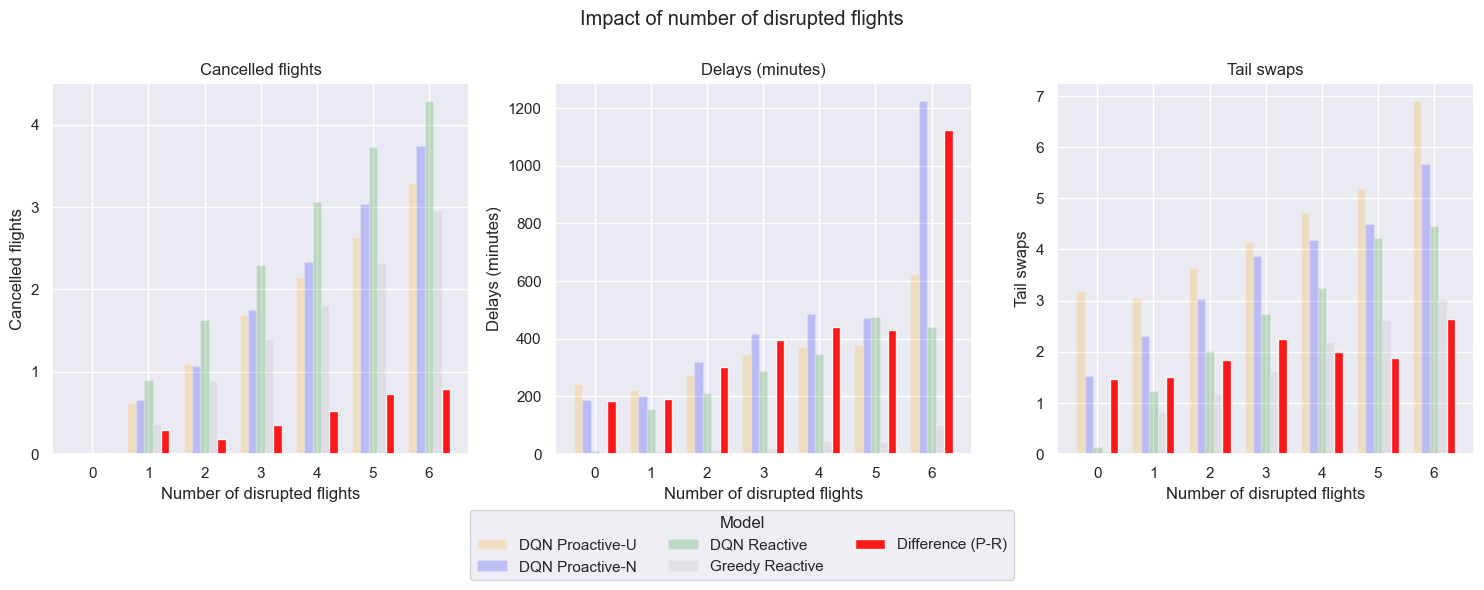

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Print number of unique scenarios per disrupted flights bucket
print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Calculate number of models and adjust bar width and spacing
    n_models = len([m for m in model_colors if 'exact' not in m.lower()]) + 1  # +1 for difference bar
    bar_width = 0.15  # Reduced bar width to accommodate bars
    total_width = bar_width * n_models
    start_offset = -total_width/2 + bar_width/2  # Center the group of bars
    
    # Plot bars for each model in the specified order
    bar_offset = start_offset
    proactive_values = None
    reactive_values = None
    
    for model_name, (color, label) in model_colors.items():
        if 'myopic' in model_name.lower() or 'exact' in model_name.lower():  # Skip myopic and exact models
            continue
            
        model_data = agg_df[agg_df['Model'] == model_name].copy()
        # Sort by ActualDisruptedFlights
        model_data = model_data.sort_values(by='ActualDisruptedFlights')
        
        x = model_data['ActualDisruptedFlights'].values
        y = model_data[metric].values
        
        if 'Proactive' in label:
            proactive_values = (x, y)
        elif 'Reactive' in label:
            reactive_values = (x, y)
            
        ax.bar(
            x + bar_offset,  # Offset bars
            y,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.2
        )
        bar_offset += bar_width  # Move to next position
    
    # Add difference bar if we have both values
    if proactive_values and reactive_values:
        proactive_x, proactive_y = proactive_values
        reactive_x, reactive_y = reactive_values
        
        # Find common x values and align the arrays
        common_x = np.intersect1d(proactive_x, reactive_x)
        proactive_mask = np.isin(proactive_x, common_x)
        reactive_mask = np.isin(reactive_x, common_x)
        
        difference = proactive_y[proactive_mask] - reactive_y[reactive_mask]
        
        ax.bar(
            common_x + bar_offset,
            difference,
            width=bar_width,
            label='Difference (P-R)',
            color='red',
            alpha=0.9
        )

    ax.set_xlabel("Number of disrupted flights")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of number of disrupted flights", y=1.02)
plt.show()



Number of unique scenarios in each bucket:
Bucket 0.00-0.05: 0 scenarios
Bucket 0.05-0.10: 0 scenarios
Bucket 0.10-0.15: 0 scenarios
Bucket 0.15-0.20: 0 scenarios
Bucket 0.20-0.25: 0 scenarios
Bucket 0.25-0.30: 1 scenarios
Bucket 0.30-0.35: 34 scenarios
Bucket 0.35-0.40: 223 scenarios
Bucket 0.40-0.45: 297 scenarios
Bucket 0.45-0.50: 128 scenarios
Bucket 0.50-0.55: 17 scenarios
Bucket 0.55-0.60: 0 scenarios
Bucket 0.60-0.65: 0 scenarios
Bucket 0.65-0.70: 0 scenarios
Bucket 0.70-0.75: 0 scenarios
Bucket 0.75-0.80: 0 scenarios
Bucket 0.80-0.85: 0 scenarios
Bucket 0.85-0.90: 0 scenarios
Bucket 0.90-0.95: 0 scenarios
Bucket 0.95-1.00: 0 scenarios


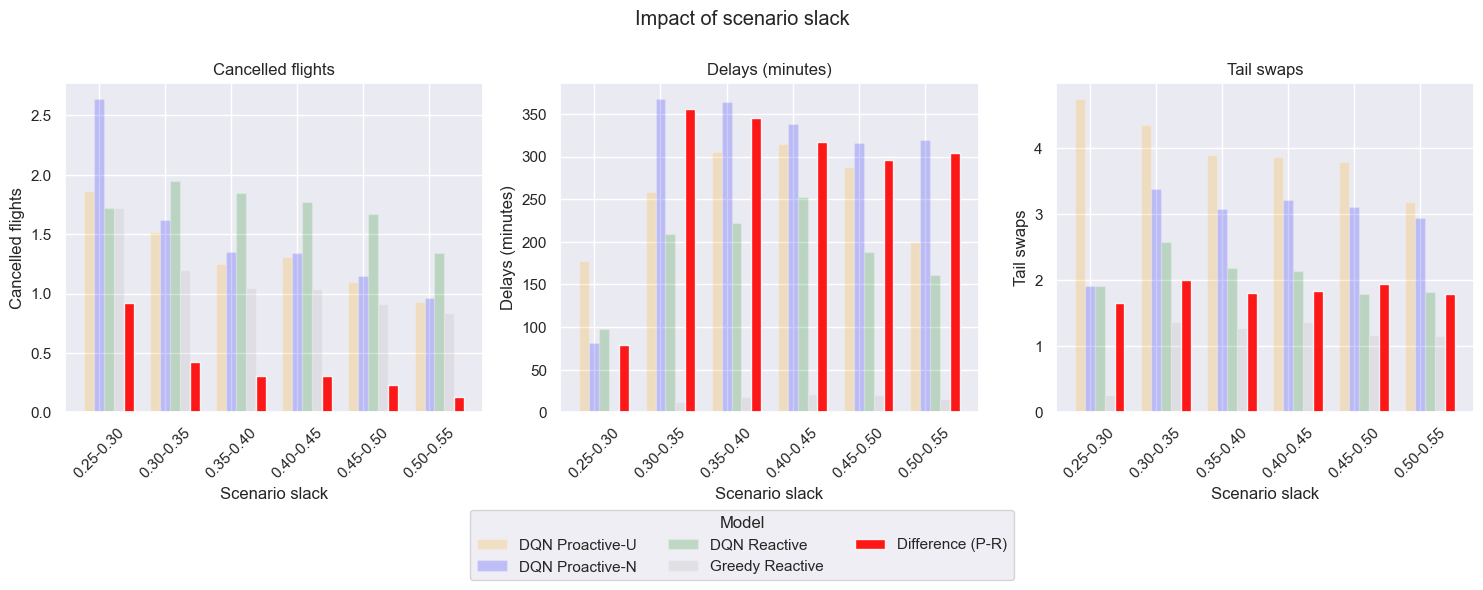

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Create slack buckets of size 0.05
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create slack intervals using the defined buckets
merged_df['SlackInterval'] = pd.cut(merged_df['ScenarioSlack'], 
                                  bins=bucket_edges,
                                  labels=bucket_labels,
                                  include_lowest=True)

# Print number of unique scenarios in each bucket
print("\nNumber of unique scenarios in each bucket:")
for bucket in bucket_labels:
    scenario_count = merged_df[merged_df['SlackInterval'] == bucket]['Scenario'].nunique()
    print(f"Bucket {bucket}: {scenario_count} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, SlackInterval)
agg_df = (
    merged_df
    .groupby(['Model', 'SlackInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where SlackInterval has no actual values
agg_df = agg_df.dropna(subset=['SlackInterval'])

# Define the display range for slack values
display_range = (0.25, 0.55)

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['SlackInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Get only the filtered slack intervals
slack_intervals = sorted(agg_df['SlackInterval'].unique())
x = np.arange(len(slack_intervals))

bar_width = 0.15  # Reduced bar width to accommodate bars

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in specific order
    bar_offset = -bar_width
    proactive_values = None
    reactive_values = None
    
    for model_name, (color, label) in model_colors.items():
        if 'myopic' in model_name.lower() or 'exact' in model_name.lower():  # Skip myopic and exact models
            continue
            
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available slack intervals
        model_values = [
            model_data[model_data['SlackInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['SlackInterval'] == interval].empty 
            else 0 
            for interval in slack_intervals
        ]
        
        if 'Proactive' in label:
            proactive_values = model_values
        elif 'Reactive' in label:
            reactive_values = model_values
            
        ax.bar(
            x + bar_offset,
            model_values,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.2
        )
        bar_offset += bar_width
    
    # Add difference bar if we have both values
    if proactive_values and reactive_values:
        difference = np.array(proactive_values) - np.array(reactive_values)
        
        ax.bar(
            x + bar_offset,
            difference,
            width=bar_width,
            label='Difference (P-R)',
            color='red',
            alpha=0.9
        )

    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(slack_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of scenario slack", y=1.02)
plt.show()


In [55]:
import pandas as pd
import statsmodels.api as sm

# ---------------------------------------------
# 1) FILTER THE DATA FOR STOCHASTIC SCENARIOS
# ---------------------------------------------
df_stoch = merged_df[ merged_df['Scenario'].str.contains('stochastic', case=False) ].copy()

# We only care about the two proactive models:
model_pair = ['DQN Proactive-U', 'DQN Proactive-N']
df_stoch = df_stoch[df_stoch['Model'].isin(model_pair)].copy()

# ---------------------------------------------
# 2) DEFINE THE 3 METRICS
# ---------------------------------------------
metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# ---------------------------------------------
# 3) PREPARE A DATAFRAME WITH U & N SIDE-BY-SIDE
# ---------------------------------------------
# Goal: For each scenario (or repeated scenario if multiple seeds),
# we want columns: 
#   Scenario,
#   AvgUncertaintyProbability,
#   (metric_U), (metric_N),  difference = metric_U - metric_N
#
# We will pivot wide on "Model" so that we get separate columns 
# for 'DQN Proactive-U' and 'DQN Proactive-N'.

# For safety, let's check we have unique (Scenario, Model) combos.
# If you have multiple seeds per scenario & model, you might need 
# to average or handle that accordingly. 
# For now, let's assume each (Scenario, Model) is unique.

# Pivot for each metric. We'll do each metric separately to keep it simple.
results = []  # we'll store regression outcomes here

for metric in metrics:
    # Pivot wide so we have columns:
    #   'Scenario' (row index),
    #   'AvgUncertaintyProbability' (should be the same across models in the same scenario),
    #   'DQN Proactive-U',
    #   'DQN Proactive-N'
    df_pivot = (
        df_stoch
        .pivot_table(index='Scenario',
                     columns='Model',
                     values=[metric, 'AvgUncertaintyProbability'], 
                     aggfunc='mean')  # 'mean' in case there's more than one row per scenario+model
    )

    # After pivot, your columns will be multi-level, something like:
    #   ( metric, 'DQN Proactive-U' ), ( metric, 'DQN Proactive-N' )
    #   ( 'AvgUncertaintyProbability', 'DQN Proactive-U' ), ...
    #
    # We can flatten these columns or just reference them directly.

    # Flatten the columns
    df_pivot.columns = [
        f"{col[0]}_{col[1]}" for col in df_pivot.columns
    ]
    df_pivot.reset_index(inplace=True)

    # Now we expect columns:
    #   Scenario
    #   TotalCancelledFlights_DQN Proactive-U
    #   TotalCancelledFlights_DQN Proactive-N
    #   AvgUncertaintyProbability_DQN Proactive-U
    #   AvgUncertaintyProbability_DQN Proactive-N
    #
    # Ideally, the 'AvgUncertaintyProbability' is identical for U & N 
    # in the same scenario. Let's just pick one for our regression.

    # Filter out rows with missing data
    df_pivot.dropna(inplace=True)

    # We'll assume the probability for U and N is the same. 
    # We'll pick the "U" one arbitrarily. 
    prob_col_U = f"AvgUncertaintyProbability_{model_pair[0]}"
    prob_col_N = f"AvgUncertaintyProbability_{model_pair[1]}"

    # Check if they're actually the same (optional)
    # If there's a scenario where they differ, you might want to investigate further.
    # For now, let's just pick the U version for the regression.
    df_pivot['Probability'] = df_pivot[prob_col_U]

    # Compute difference in metric: U minus N
    metric_U = f"{metric}_{model_pair[0]}"
    metric_N = f"{metric}_{model_pair[1]}"
    df_pivot['Diff'] = df_pivot[metric_U] - df_pivot[metric_N]

    # ---------------------------------------------
    # 4) LINEAR REGRESSION: difference ~ probability*100
    # ---------------------------------------------
    # This way, the slope = "difference per 1% increase"
    X = df_pivot['Probability'] * 100.0  # convert from fraction to percent
    y = df_pivot['Diff']

    # Add intercept
    X = sm.add_constant(X)

    # Fit OLS
    model = sm.OLS(y, X).fit()

    # Extract results
    intercept = model.params['const']
    slope = model.params[X.columns[-1]]  # the last column is the Probability*100
    p_val = model.pvalues[X.columns[-1]]
    r_sq = model.rsquared

    results.append({
        'Metric': metric,
        'Intercept': intercept,
        'Slope_per_1pct': slope,
        'p_value': p_val,
        'R_squared': r_sq,
        'NumDataPoints': len(df_pivot)
    })

# ---------------------------------------------
# 5) PRINT THE RESULTS
# ---------------------------------------------
print("=== Regression of Difference (U minus N) vs. Probability (per 1%) ===")
for res in results:
    m = res['Metric']
    inter = res['Intercept']
    slope = res['Slope_per_1pct']
    pval  = res['p_value']
    r2    = res['R_squared']
    n     = res['NumDataPoints']
    print(f"\nMetric: {m}")
    print(f"  Num Data Points    : {n}")
    print(f"  Intercept          : {inter:.4f}")
    print(f"  Slope (per 1%)     : {slope:.4f}")
    print(f"  p-value (slope)    : {pval:.6f}")
    print(f"  R-squared          : {r2:.4f}")



=== Regression of Difference (U minus N) vs. Probability (per 1%) ===

Metric: TotalCancelledFlights
  Num Data Points    : 300
  Intercept          : 0.2233
  Slope (per 1%)     : -0.0080
  p-value (slope)    : 0.000100
  R-squared          : 0.0496

Metric: TotalDelays
  Num Data Points    : 300
  Intercept          : 49.5821
  Slope (per 1%)     : -0.7904
  p-value (slope)    : 0.550234
  R-squared          : 0.0012

Metric: TailSwaps
  Num Data Points    : 300
  Intercept          : 1.9680
  Slope (per 1%)     : -0.0095
  p-value (slope)    : 0.121428
  R-squared          : 0.0080


In [56]:
import pandas as pd
import statsmodels.api as sm

# ---------------------------------------------
# 1) PREPARE THE DATA (ALL SCENARIOS)
# ---------------------------------------------
# We'll assume 'merged_df' has columns:
#   'Scenario'
#   'Model'   in ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
#   'ActualDisruptedFlights' (integer)
#   'TotalCancelledFlights'
#   'TotalDelays'
#   'TailSwaps'

df_all = merged_df.copy()

# The 4 models to consider
model_list = [
    'DQN Proactive-U',
    'DQN Proactive-N', 
    'DQN Reactive',
    'Greedy Reactive'
]

# The 3 metrics to analyze
metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# ---------------------------------------------
# 2) PIVOT WIDE FOR EACH METRIC
# ---------------------------------------------
# We'll store final results in a list of dicts
results = []

for metric in metrics:
    # Create a wide form DataFrame
    df_pivot = (
        df_all
        .pivot_table(index='Scenario',
                     columns='Model',
                     values=[metric, 'ActualDisruptedFlights'],
                     aggfunc='mean')
        .reset_index()
    )
    
    # Flatten column names
    df_pivot.columns = [
        f"{col[0]}_{col[1]}" if col[1] in model_list else str(col[0])
        for col in df_pivot.columns
    ]
    
    # Filter out rows if any model is missing
    df_pivot.dropna(inplace=True)
    
    # We only need one "ActualDisruptedFlights" column
    disrupted_col = f"ActualDisruptedFlights_{model_list[-1]}"
    if disrupted_col not in df_pivot.columns:
        possible_cols = [c for c in df_pivot.columns if c.startswith('ActualDisruptedFlights_')]
        disrupted_col = possible_cols[0]
    
    df_pivot.rename(columns={disrupted_col: 'DisruptedFlightsRef'}, inplace=True)
    
    # ---------------------------------------------
    # 3) FOR EACH MODEL, REGRESS METRIC ON DISRUPTED FLIGHTS
    # ---------------------------------------------
    for model in model_list:
        # Column name for this metric-model combination
        col = f"{metric}_{model}"
        
        # Check if column exists
        if col not in df_pivot.columns:
            continue
            
        # Drop missing data
        df_clean = df_pivot.dropna(subset=[col, 'DisruptedFlightsRef'])
        
        if len(df_clean) < 2:
            continue
        
        # Fit OLS: Metric ~ DisruptedFlights
        X = sm.add_constant(df_clean['DisruptedFlightsRef'])
        y = df_clean[col]
        model_ols = sm.OLS(y, X).fit()
        
        slope = model_ols.params['DisruptedFlightsRef']
        intercept = model_ols.params['const']
        p_val = model_ols.pvalues['DisruptedFlightsRef']
        r2 = model_ols.rsquared
        n = len(df_clean)
        
        results.append({
            'Metric': metric,
            'Model': model,
            'Intercept': intercept,
            'Slope_per_disruptedFlight': slope,
            'p_value': p_val,
            'R_squared': r2,
            'NumDataPoints': n
        })

# ---------------------------------------------
# 4) PRINT RESULTS
# ---------------------------------------------
print("=== Metric Values Regressed on # of Disrupted Flights ===")
for res in results:
    print(
        f"\nMetric: {res['Metric']}\n"
        f"Model: {res['Model']}\n"
        f"  N (scenarios)           : {res['NumDataPoints']}\n"
        f"  Intercept               : {res['Intercept']:.4f}\n"
        f"  Slope (per disrupted)   : {res['Slope_per_disruptedFlight']:.4f}\n"
        f"  p-value (slope)         : {res['p_value']:.6f}\n"
        f"  R-squared               : {res['R_squared']:.4f}"
    )


=== Metric Values Regressed on # of Disrupted Flights ===

Metric: TotalCancelledFlights
Model: DQN Proactive-U
  N (scenarios)           : 700
  Intercept               : 0.1060
  Slope (per disrupted)   : 0.5056
  p-value (slope)         : 0.000000
  R-squared               : 0.4260

Metric: TotalCancelledFlights
Model: DQN Proactive-N
  N (scenarios)           : 700
  Intercept               : 0.1060
  Slope (per disrupted)   : 0.5341
  p-value (slope)         : 0.000000
  R-squared               : 0.4369

Metric: TotalCancelledFlights
Model: DQN Reactive
  N (scenarios)           : 700
  Intercept               : 0.1738
  Slope (per disrupted)   : 0.7069
  p-value (slope)         : 0.000000
  R-squared               : 0.6687

Metric: TotalCancelledFlights
Model: Greedy Reactive
  N (scenarios)           : 700
  Intercept               : 0.1560
  Slope (per disrupted)   : 0.3822
  p-value (slope)         : 0.000000
  R-squared               : 0.4844

Metric: TotalDelays
Model: DQN P

In [57]:
import pandas as pd
import statsmodels.api as sm

# ---------------------------------------------
# 1) PREPARE THE DATA (ALL SCENARIOS)
# ---------------------------------------------
# We'll assume 'merged_df' has columns:
#   'Scenario'
#   'Model'   in ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
#   'ScenarioSlack'
#   'TotalCancelledFlights'
#   'TotalDelays'
#   'TailSwaps'

df_all = merged_df.copy()

# The 4 models to consider
model_list = [
    'DQN Proactive-U',
    'DQN Proactive-N', 
    'DQN Reactive',
    'Greedy Reactive'
]

# The 3 metrics to analyze
metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# ---------------------------------------------
# 2) PIVOT WIDE FOR EACH METRIC
# ---------------------------------------------
# We'll store final results in a list of dicts
results = []

for metric in metrics:
    # Create a wide form DataFrame
    df_pivot = (
        df_all
        .pivot_table(index='Scenario',
                     columns='Model',
                     values=[metric, 'ScenarioSlack'],
                     aggfunc='mean')
        .reset_index()
    )
    
    # Flatten column names
    df_pivot.columns = [
        f"{col[0]}_{col[1]}" if col[1] in model_list else str(col[0])
        for col in df_pivot.columns
    ]
    
    # Filter out rows if any model is missing
    df_pivot.dropna(inplace=True)
    
    # We only need one "ScenarioSlack" column
    slack_col = f"ScenarioSlack_{model_list[-1]}"
    if slack_col not in df_pivot.columns:
        possible_cols = [c for c in df_pivot.columns if c.startswith('ScenarioSlack_')]
        slack_col = possible_cols[0]
    
    df_pivot.rename(columns={slack_col: 'SlackRef'}, inplace=True)
    
    # ---------------------------------------------
    # 3) FOR EACH MODEL, REGRESS METRIC ON SCENARIO SLACK
    # ---------------------------------------------
    for model in model_list:
        # Column name for this metric-model combination
        col = f"{metric}_{model}"
        
        # Check if column exists
        if col not in df_pivot.columns:
            continue
            
        # Drop missing data
        df_clean = df_pivot.dropna(subset=[col, 'SlackRef'])
        
        if len(df_clean) < 2:
            continue
        
        # Fit OLS: Metric ~ ScenarioSlack
        # Multiply slack by 100 to get percentage points
        X = sm.add_constant(df_clean['SlackRef'] * 100)
        y = df_clean[col]
        model_ols = sm.OLS(y, X).fit()
        
        # Now slope represents change per 1% increase in slack
        slope = model_ols.params['SlackRef']
        intercept = model_ols.params['const']
        p_val = model_ols.pvalues['SlackRef']
        r2 = model_ols.rsquared
        n = len(df_clean)
        
        results.append({
            'Metric': metric,
            'Model': model,
            'Intercept': intercept,
            'Slope_per_percent_slack': slope,
            'p_value': p_val,
            'R_squared': r2,
            'NumDataPoints': n
        })

# ---------------------------------------------
# 4) PRINT RESULTS
# ---------------------------------------------
print("=== Metric Values Regressed on Scenario Slack ===")
for res in results:
    print(
        f"\nMetric: {res['Metric']}\n"
        f"Model: {res['Model']}\n"
        f"  N (scenarios)           : {res['NumDataPoints']}\n"
        f"  Intercept               : {res['Intercept']:.4f}\n"
        f"  Slope (per 1% slack)    : {res['Slope_per_percent_slack']:.4f}\n"
        f"  p-value (slope)         : {res['p_value']:.6f}\n"
        f"  R-squared               : {res['R_squared']:.4f}"
    )


=== Metric Values Regressed on Scenario Slack ===

Metric: TotalCancelledFlights
Model: DQN Proactive-U
  N (scenarios)           : 700
  Intercept               : 2.0370
  Slope (per 1% slack)    : -0.0189
  p-value (slope)         : 0.022651
  R-squared               : 0.0074

Metric: TotalCancelledFlights
Model: DQN Proactive-N
  N (scenarios)           : 700
  Intercept               : 2.4807
  Slope (per 1% slack)    : -0.0280
  p-value (slope)         : 0.001171
  R-squared               : 0.0150

Metric: TotalCancelledFlights
Model: DQN Reactive
  N (scenarios)           : 700
  Intercept               : 2.4558
  Slope (per 1% slack)    : -0.0163
  p-value (slope)         : 0.077426
  R-squared               : 0.0045

Metric: TotalCancelledFlights
Model: Greedy Reactive
  N (scenarios)           : 700
  Intercept               : 1.7082
  Slope (per 1% slack)    : -0.0165
  p-value (slope)         : 0.004933
  R-squared               : 0.0113

Metric: TotalDelays
Model: DQN Proac

In [58]:
import pandas as pd
import statsmodels.api as sm

# ---------------------------------------------
# 1) PREPARE THE DATA (ALL SCENARIOS)
# ---------------------------------------------
# We'll assume 'merged_df' has columns:
#   'Scenario'
#   'Model'   in ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
#   'ScenarioSlack'
#   'TotalCancelledFlights'
#   'TotalDelays'
#   'TailSwaps'

df_all = merged_df.copy()

# The 4 models to consider
model_list = [
    'DQN Proactive-U',
    'DQN Proactive-N', 
    'DQN Reactive',
    'Greedy Reactive'
]

# The 3 metrics to analyze
metrics = [
    'TotalCancelledFlights',
    'TotalDelays',
    'TailSwaps'
]

# ---------------------------------------------
# 2) PIVOT WIDE FOR EACH METRIC
# ---------------------------------------------
# We'll store final results in a list of dicts
results = []

for metric in metrics:
    # Create a wide form DataFrame
    df_pivot = (
        df_all
        .pivot_table(index='Scenario',
                     columns='Model',
                     values=[metric, 'ScenarioSlack'],
                     aggfunc='mean')
        .reset_index()
    )
    
    # Flatten column names
    df_pivot.columns = [
        f"{col[0]}_{col[1]}" if col[1] in model_list else str(col[0])
        for col in df_pivot.columns
    ]
    
    # Filter out rows if any model is missing
    df_pivot.dropna(inplace=True)
    
    # We only need one "ScenarioSlack" column
    slack_col = f"ScenarioSlack_{model_list[-1]}"
    if slack_col not in df_pivot.columns:
        possible_cols = [c for c in df_pivot.columns if c.startswith('ScenarioSlack_')]
        slack_col = possible_cols[0]
    
    df_pivot.rename(columns={slack_col: 'SlackRef'}, inplace=True)
    
    # ---------------------------------------------
    # 3) FOR EACH MODEL, REGRESS METRIC ON SCENARIO SLACK
    # ---------------------------------------------
    for model in model_list:
        # Column name for this metric-model combination
        col = f"{metric}_{model}"
        
        # Check if column exists
        if col not in df_pivot.columns:
            continue
            
        # Drop missing data
        df_clean = df_pivot.dropna(subset=[col, 'SlackRef'])
        
        if len(df_clean) < 2:
            continue
        
        # Fit OLS: Metric ~ ScenarioSlack
        # Multiply slack by 100 to get percentage points
        X = sm.add_constant(df_clean['SlackRef'] * 100)
        y = df_clean[col]
        model_ols = sm.OLS(y, X).fit()
        
        # Now slope represents change per 1% increase in slack
        slope = model_ols.params['SlackRef']
        intercept = model_ols.params['const']
        p_val = model_ols.pvalues['SlackRef']
        r2 = model_ols.rsquared
        n = len(df_clean)
        
        results.append({
            'Metric': metric,
            'Model': model,
            'Intercept': intercept,
            'Slope_per_percent_slack': slope,
            'p_value': p_val,
            'R_squared': r2,
            'NumDataPoints': n
        })

# ---------------------------------------------
# 4) PRINT RESULTS
# ---------------------------------------------
print("=== Metric Values Regressed on Scenario Slack ===")
for res in results:
    print(
        f"\nMetric: {res['Metric']}\n"
        f"Model: {res['Model']}\n"
        f"  N (scenarios)           : {res['NumDataPoints']}\n"
        f"  Intercept               : {res['Intercept']:.4f}\n"
        f"  Slope (per 1% slack)    : {res['Slope_per_percent_slack']:.4f}\n"
        f"  p-value (slope)         : {res['p_value']:.6f}\n"
        f"  R-squared               : {res['R_squared']:.4f}"
    )


=== Metric Values Regressed on Scenario Slack ===

Metric: TotalCancelledFlights
Model: DQN Proactive-U
  N (scenarios)           : 700
  Intercept               : 2.0370
  Slope (per 1% slack)    : -0.0189
  p-value (slope)         : 0.022651
  R-squared               : 0.0074

Metric: TotalCancelledFlights
Model: DQN Proactive-N
  N (scenarios)           : 700
  Intercept               : 2.4807
  Slope (per 1% slack)    : -0.0280
  p-value (slope)         : 0.001171
  R-squared               : 0.0150

Metric: TotalCancelledFlights
Model: DQN Reactive
  N (scenarios)           : 700
  Intercept               : 2.4558
  Slope (per 1% slack)    : -0.0163
  p-value (slope)         : 0.077426
  R-squared               : 0.0045

Metric: TotalCancelledFlights
Model: Greedy Reactive
  N (scenarios)           : 700
  Intercept               : 1.7082
  Slope (per 1% slack)    : -0.0165
  p-value (slope)         : 0.004933
  R-squared               : 0.0113

Metric: TotalDelays
Model: DQN Proac